# Connect to google account

In [ ]:
from google.colab import drive
drive.mount('/content/data')

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


In [ ]:
# 코렙 한글깨짐 방지
!apt -qq -y install fonts-nanum > /dev/null

# 데이터 시각화에 사용할 라이브러리
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=fontpath).get_name() 
# fm._rebuild() 


%config InlineBackend.figure_format = 'retina'

plt.rc('font', family=font_name)  
plt.rcParams['axes.unicode_minus'] = False

# Global Variables

In [ ]:
import easydict
import json
args = easydict.EasyDict()

# path 정보
args.default_path = '/content/data/MyDrive/lecture/data/titanic/kaggle_competition/'
args.train_csv = args.default_path+'train.csv'
args.test_csv = args.default_path+'test.csv'
args.default_submission_csv = args.default_path+'submission.csv'

args.submission_csv = args.default_path+'result/submission_0220.csv'
args.save_results = args.default_path+"result/model_results.json"

# 데이터 분석을 위한 변수들
args.random_state = 42
args.results = []
with open(args.save_results, 'r') as file:
    args.results = json.load(file)

args.results

[{'model': 'modelV1',
  'score_tr': 0.9828393136,
  'score_te': 0.7854545455,
  'auc_te': 0.8572593342,
  'len_features': 10,
  'feaute_importances': ['gender_female',
   'fare',
   'age',
   'pclass',
   'sibsp',
   'embarked_S',
   'embarked_C',
   'parch',
   'embarked_Q',
   'gender_male'],
  'create_dt': '0217'},
 {'model': 'modelV3',
  'score_tr': 0.9937597504,
  'score_te': 0.8145454545,
  'auc_te': 0.8128092668,
  'len_features': 19,
  'feaute_importances': ['gender_male',
   'fare_cleaning',
   'age_cleaning',
   'pclass_3',
   'sibsp',
   'len_ticket_1',
   'parch',
   'embarked_Q',
   'embarked_C',
   'len_ticket_2',
   'pclass_2',
   'Initial_name_type_Royalty',
   'len_ticket_3',
   'Initial_name_type_Officer',
   'gender_female',
   'embarked_S',
   'Initial_name_type_Others',
   'initial_cabin_unknown',
   'pclass_1'],
  'create_dt': '0220'},
 {'model': 'modelV4',
  'score_tr': 0.9906396256,
  'score_te': 0.7963636364,
  'auc_te': 0.7961088619,
  'len_features': 38,
  'f

# Load Tritanic

- Surived:0=사망, 1=생존
- Pclass: 1=1등석, 2=2등석, 3=3등석
- Sex:male=남성, female=여성
- Age: 나이
- SibSp: 타이타닉 호에 동승한 자매/배우자의 수
- Parch: 타이타닉 호에 동승한 부모/자식의 수
- Ticket: 티켓 번호
- Fare: 승객 요금
- Cabin: 방 호수
- Embarked: 탑승지; C=셰르부르, Q=퀴즈타운, S=사우샘프턴

In [ ]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
plt.ion()

import warnings
warnings.filterwarnings('ignore')

In [ ]:
ori_train = pd.read_csv(args.train_csv)
ori_test = pd.read_csv(args.test_csv)

ori_train.shape, ori_test.shape

((916, 12), (393, 11))

In [ ]:
ori_train['passengerid'].nunique(), ori_train.shape[0]

(916, 916)

In [ ]:
ori_train.drop('passengerid', axis=1, inplace=True)
ori_train.shape

(916, 11)

In [ ]:
ori_test.set_index(['passengerid'], inplace=True) 
ori_test.shape

(393, 10)

# ModelV3

## train_test_split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
ori_te = ori_test.copy()

y = ori_train['survived']
X = ori_train.drop(['survived'], axis=1)

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, stratify=ori_train['survived'], random_state=args.random_state)

X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((641, 10), (275, 10), (641,), (275,))

## Feature Extraction

Initial_name

In [ ]:
X_tr['Initial_name'] = X_tr['name'].str.extract('([A-Za-z]+)\.') #lets extract the Salutations
X_te['Initial_name'] = X_te['name'].str.extract('([A-Za-z]+)\.') #lets extract the Salutations
ori_te['Initial_name'] = ori_te['name'].str.extract('([A-Za-z]+)\.') #lets extract the Salutations

X_tr.drop(['name'], axis=1, inplace=True)
X_te.drop(['name'], axis=1, inplace=True)
ori_te.drop(['name'], axis=1, inplace=True)

print(f'Initial_name: {X_tr["Initial_name"].isnull().sum()} / {X_te["Initial_name"].isnull().sum()} / {ori_te["Initial_name"].isnull().sum()}')

Initial_name: 0 / 0 / 0


Initial_name_type

In [ ]:
X_tr['Initial_name'].unique()

array(['Mr', 'Miss', 'Mrs', 'Master', 'Jonkheer', 'Dr', 'Countess', 'Rev',
       'Col', 'Major', 'Sir', 'Capt'], dtype=object)

In [ ]:
X_tr['Initial_name'].value_counts() 

Mr          371
Miss        127
Mrs          93
Master       32
Rev           5
Dr            4
Col           3
Major         2
Jonkheer      1
Countess      1
Sir           1
Capt          1
Name: Initial_name, dtype: int64

성별 기준으로 최빈값이 Mr, Miss이며,   
Mr, Miss는 모두 Others 이다.

In [ ]:
dict_initial_name = {
    'Mr': 'Others',
    'Miss': 'Others',
    'Mrs': 'Others',

    'Master': 'Officer',
    'Dr': 'Officer',
    'Rev': 'Officer',
    'Col': 'Officer',
    'Major': 'Officer',
    'Capt': 'Officer',

    'Jonkheer': 'Royalty',
    'Countess': 'Royalty',
    'Sir': 'Royalty'
}

def add_initial_name_type(initial_name):
  result = 'Others'
  try:
    result = dict_initial_name[initial_name]
  except:
    pass 
  return result

X_tr['Initial_name_type'] = X_tr['Initial_name'].map(lambda x: add_initial_name_type(x))
X_te['Initial_name_type'] = X_te['Initial_name'].map(lambda x: add_initial_name_type(x))
ori_te['Initial_name_type'] = ori_te['Initial_name'].map(lambda x: add_initial_name_type(x))

X_tr.drop(['Initial_name'], axis=1, inplace=True)
X_te.drop(['Initial_name'], axis=1, inplace=True)
ori_te.drop(['Initial_name'], axis=1, inplace=True)

print(f'Initial_name_type: {X_tr["Initial_name_type"].isnull().sum()} / {X_te["Initial_name_type"].isnull().sum()} / {ori_te["Initial_name_type"].isnull().sum()}')

Initial_name_type: 0 / 0 / 0


initial_cabin

In [ ]:
def add_initial_cabin(cabin, initial_cabin_unique=None):
  result = 'unknown'
  try:
    cabin = cabin.strip()
    if cabin[:1] in initial_cabin_unique:
      result = cabin[:1]
  except:
    pass 
  
  return result

X_tr['initial_cabin'] = X_tr['cabin'].map(lambda cabin: add_initial_cabin(cabin))
initial_cabin_unique = list(X_tr['initial_cabin'].unique())

X_te['initial_cabin'] = X_te['cabin'].map(lambda cabin: add_initial_cabin(cabin, initial_cabin_unique))
ori_te['initial_cabin'] = ori_te['cabin'].map(lambda cabin: add_initial_cabin(cabin, initial_cabin_unique))

X_tr.drop(['cabin'], axis=1, inplace=True)
X_te.drop(['cabin'], axis=1, inplace=True)
ori_te.drop(['cabin'], axis=1, inplace=True)

print(f'initial_cabin: {X_tr["initial_cabin"].isnull().sum()} / {X_te["initial_cabin"].isnull().sum()} / {ori_te["initial_cabin"].isnull().sum()}')

initial_cabin: 0 / 0 / 0


len_ticket

In [ ]:
X_tr['len_ticket'] = X_tr['ticket'].map(lambda x: len(x.strip().split(' ')))
X_te['len_ticket'] = X_te['ticket'].map(lambda x: len(x.strip().split(' ')))
ori_te['len_ticket'] = ori_te['ticket'].map(lambda x: len(x.strip().split(' ')))

X_tr.drop(['ticket'], axis=1, inplace=True)
X_te.drop(['ticket'], axis=1, inplace=True)
ori_te.drop(['ticket'], axis=1, inplace=True)

print(f'len_ticket: {X_tr["len_ticket"].isnull().sum()} / {X_te["len_ticket"].isnull().sum()} / {ori_te["len_ticket"].isnull().sum()}')

len_ticket: 0 / 0 / 0


## Data Cleaning

In [ ]:
print(f'train: {X_tr.isnull().sum().sum()} / test: {X_te.isnull().sum().sum()} / ori_te: {ori_te.isnull().sum().sum()}')

train: 118 / test: 63 / ori_te: 85


In [ ]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

def get_cols_cleaning(p_pd_list:list) -> list:
  cols_cleaning = []
  for df in p_pd_list:
    # 결측치 컬럼 조회
    tmp = df.isnull().sum()
    cols_cleaning += list(tmp[df.isnull().sum() > 0].index)

  cols_cleaning = list(set(cols_cleaning))
  print(f'cols_cleaning: {cols_cleaning}')
  return cols_cleaning

def add_cols_cleaning(p_train:pd.DataFrame, p_test:pd.DataFrame, p_ori_te:pd.DataFrame) -> None:
  pd_list = [p_train, p_test, p_ori_te]
  for col in get_cols_cleaning(pd_list):  
    for i, df in enumerate(pd_list, start=1):
      
      if is_numeric_dtype(df[col]): # 숫자형 결측치 처리
        new_col = col+'_cleaning'
        df[new_col] = df[col]   
        # random sampling
        random_sampling = (p_train[col].dropna().sample(df[col].isnull().sum()))
        # index 부여
        random_sampling.index = df[lambda x: x[col].isnull()].index 
        # NA imputation
        df.loc[df[col].isnull(), new_col] = random_sampling
        
        # 기존 결측치 컬럼 제거
        if i == len(pd_list):
          for _df in pd_list:
            _df.drop([col], axis=1, inplace=True)
      
      else: # 범주형 결측치 처리
        df[col].fillna(p_train[col].mode().values[0], inplace=True)

  print(f'p_train: {p_train.isnull().sum().sum()} / p_test: {p_test.isnull().sum().sum()} / p_ori_te: {p_ori_te.isnull().sum().sum()}')


In [ ]:
add_cols_cleaning(X_tr, X_te, ori_te)

cols_cleaning: ['fare', 'embarked', 'age']
p_train: 0 / p_test: 0 / p_ori_te: 0


In [ ]:
print(f'train: {X_tr.isnull().sum().sum()} / test: {X_te.isnull().sum().sum()} / ori_te: {ori_te.isnull().sum().sum()}')

train: 0 / test: 0 / ori_te: 0


## Encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
def add_cols_encoding(p_train:pd.DataFrame, p_test:pd.DataFrame, p_ori_te:pd.DataFrame) -> None:
  print(f'before: {p_train.shape} / {p_test.shape} / {p_ori_te.shape}')
  results = []

  enc_cols = ['pclass', 'gender', 'embarked', 'Initial_name_type', 'initial_cabin', 'len_ticket']
  normal_cols = list(set(p_train.columns) - set(enc_cols))

  enc = OneHotEncoder()
  enc.fit(p_train[enc_cols])

  pd_list = [p_train, p_test, p_ori_te]
  for i, df in enumerate(pd_list, start=1):
    _df = pd.DataFrame(
      enc.transform(df[enc_cols]).toarray(),
      columns = enc.get_feature_names_out()
    )
    results.append( 
      pd.concat(
        [df[normal_cols].reset_index(drop=True), _df.reset_index(drop=True)]
        , axis=1
      ).reset_index(drop=True)
    )

  print(f'after: {results[0].shape} / {results[1].shape} / {results[2].shape}')
  return results[0], results[1], results[2]

In [ ]:
X_tr, X_te, ori_te = add_cols_encoding(X_tr, X_te, ori_te)

before: (641, 10) / (275, 10) / (393, 10)
after: (641, 19) / (275, 19) / (393, 19)


In [ ]:
X_tr.head()

,fare_cleaning,sibsp,parch,age_cleaning,pclass_1,pclass_2,pclass_3,gender_female,gender_male,embarked_C,embarked_Q,embarked_S,Initial_name_type_Officer,Initial_name_type_Others,Initial_name_type_Royalty,initial_cabin_unknown,len_ticket_1,len_ticket_2,len_ticket_3
0,26.5500,0,0,30.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
1,135.6333,0,0,36.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,8.0500,0,0,22.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,8.6625,2,0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,7.8792,0,0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


## Modeling

In [ ]:
X_tr.isnull().sum().sum(), X_te.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

In [ ]:
X_tr.shape, X_te.shape, ori_te.shape

((641, 19), (275, 19), (393, 19))

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
modelV3 = DecisionTreeClassifier(random_state=args.random_state)

print(f'{X_tr.shape} / {y_tr.shape}')
modelV3.fit(X_tr, y_tr)

(641, 19) / (641,)


DecisionTreeClassifier(random_state=42)

## Evaluation

In [ ]:
score_tr = modelV3.score(X_tr, y_tr)
score_te = modelV3.score(X_te, y_te) 

score_tr, score_te  

(0.9921996879875195, 0.7963636363636364)

In [ ]:
from sklearn.metrics import roc_curve, auc 

y_pred = modelV3.predict_proba(X_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te,y_pred)
auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

model: 0.7850877192982457


In [ ]:
ori_te_pred = modelV3.predict_proba(ori_te)[:,1]
ori_te_pred.shape

(393,)

In [ ]:
df_feature_importances = pd.DataFrame(modelV3.feature_importances_, X_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances

(19, 2)


,index,0
0,gender_male,0.529397
1,age_cleaning,0.172153
2,fare_cleaning,0.166315
3,sibsp,0.022883
4,pclass_3,0.022520
5,parch,0.015542
6,embarked_S,0.015240
7,embarked_Q,0.010937
8,pclass_2,0.010179
9,len_ticket_1,0.009325


In [ ]:
args.results.append(
    {
        'model': 'modelV3',
        'score_tr': score_tr,
        'score_te': score_te,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': '0220'
    }
)

In [ ]:
pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False)

,model,score_tr,score_te,auc_te,len_features,feaute_importances,create_dt,ori_te_pred
0,modelV1,0.982839,0.785455,0.857259,10,"[gender_female, fare, age, pclass, sibsp, emba...",0217,NaN
1,modelV3,0.993760,0.814545,0.812809,19,"[gender_male, fare_cleaning, age_cleaning, pcl...",0220,NaN
2,modelV4,0.990640,0.796364,0.796109,38,"[gender_female, age_cleaning, fare_cleaning, g...",0220,NaN
5,modelV3,0.992200,0.796364,0.785088,19,"[gender_male, age_cleaning, fare_cleaning, sib...",0220,"[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
3,modelV2,0.982839,0.778182,0.766616,10,"[gender_female, fare, age, pclass, sibsp, emba...",0217,NaN
4,modelV0,0.982839,0.774545,0.763580,10,"[gender_female, fare, age, pclass, sibsp, emba...",0217,NaN


# ModelV4

In [ ]:
ori_tr = ori_train.copy()
ori_te = ori_test.copy()

ori_tr.shape, ori_te.shape

((916, 11), (393, 10))

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, test = train_test_split(ori_tr, test_size=0.3, stratify=ori_tr['survived'], random_state=args.random_state)

train.shape, test.shape

((641, 11), (275, 11))

- cabin: 학습에 도움이 안됨!!, 삭제 필요!!

In [ ]:
train.drop('cabin', axis=1, inplace=True)
test.drop('cabin', axis=1, inplace=True)
ori_te.drop('cabin', axis=1, inplace=True)

train.shape, test.shape, ori_te.shape

((641, 10), (275, 10), (393, 9))

## Feature Extraction with EDA

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641 entries, 539 to 636
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  641 non-null    int64  
 1   pclass    641 non-null    int64  
 2   name      641 non-null    object 
 3   gender    641 non-null    object 
 4   age       523 non-null    float64
 5   sibsp     641 non-null    int64  
 6   parch     641 non-null    int64  
 7   ticket    641 non-null    object 
 8   fare      641 non-null    float64
 9   embarked  641 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 55.1+ KB


### continous features

In [ ]:
continous_cols = ['age', 'fare'] + ['survived']

train[continous_cols].describe()

,age,fare,survived
count,523.000000,641.000000,641.000000
mean,29.853576,31.941796,0.377535
std,14.536210,47.068732,0.485149
min,0.170000,0.000000,0.000000
25%,21.000000,7.925000,0.000000
50%,28.000000,14.500000,0.000000
75%,38.000000,30.000000,1.000000
max,80.000000,512.329200,1.000000


In [ ]:
train[continous_cols].corr()

,age,fare,survived
age,1.000000,0.151860,-0.040994
fare,0.151860,1.000000,0.176041
survived,-0.040994,0.176041,1.000000


age

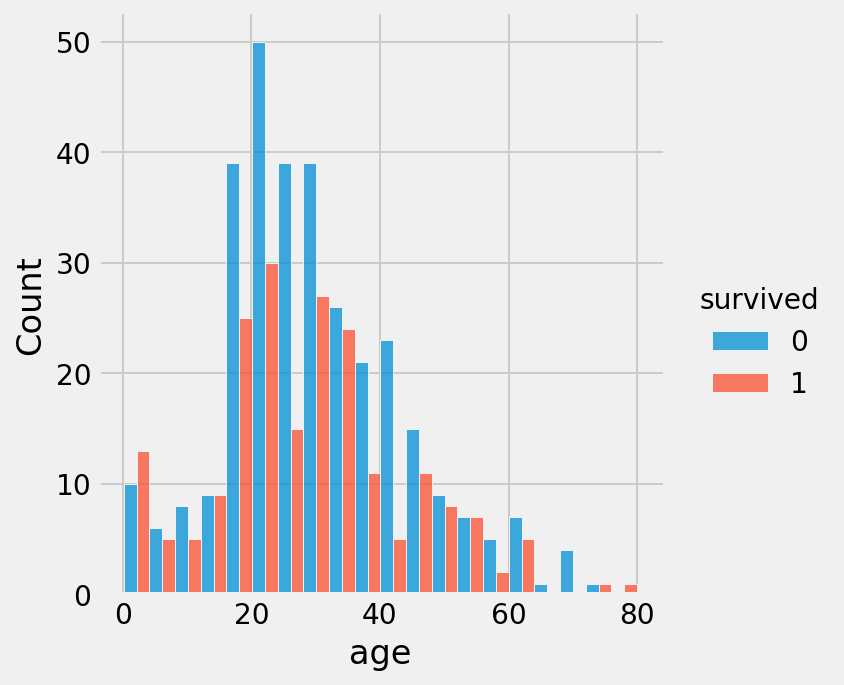

In [ ]:
sns.displot(train, x='age', hue="survived", multiple="dodge", bins=20)

In [ ]:
c1 = train['age'] <= 5
train.loc[c1]['survived'].mean()

0.6

In [ ]:
c1 = train['age'] <= 10
c2 = train['age'] > 5
c = c1 &c2
train.loc[c]['survived'].mean() 

0.3125

In [ ]:
c1 = train['age'] > 5
train.loc[c1]['survived'].mean()

0.3795180722891566

add infant

In [ ]:
def add_infant(age):
  result = 0
  try:
    if age <= 5:
      result = 1
  except:
    pass
  return result

train['infant'] = train['age'].map(lambda x: add_infant(x))
test['infant'] = test['age'].map(lambda x: add_infant(x))
ori_te['infant'] = ori_te['age'].map(lambda x: add_infant(x))

print(f"{train['infant'].nunique()} / \n {train['infant'].unique()} \n")
train.shape, test.shape, ori_te.shape 

2 / 
 [0 1] 



((641, 11), (275, 11), (393, 10))

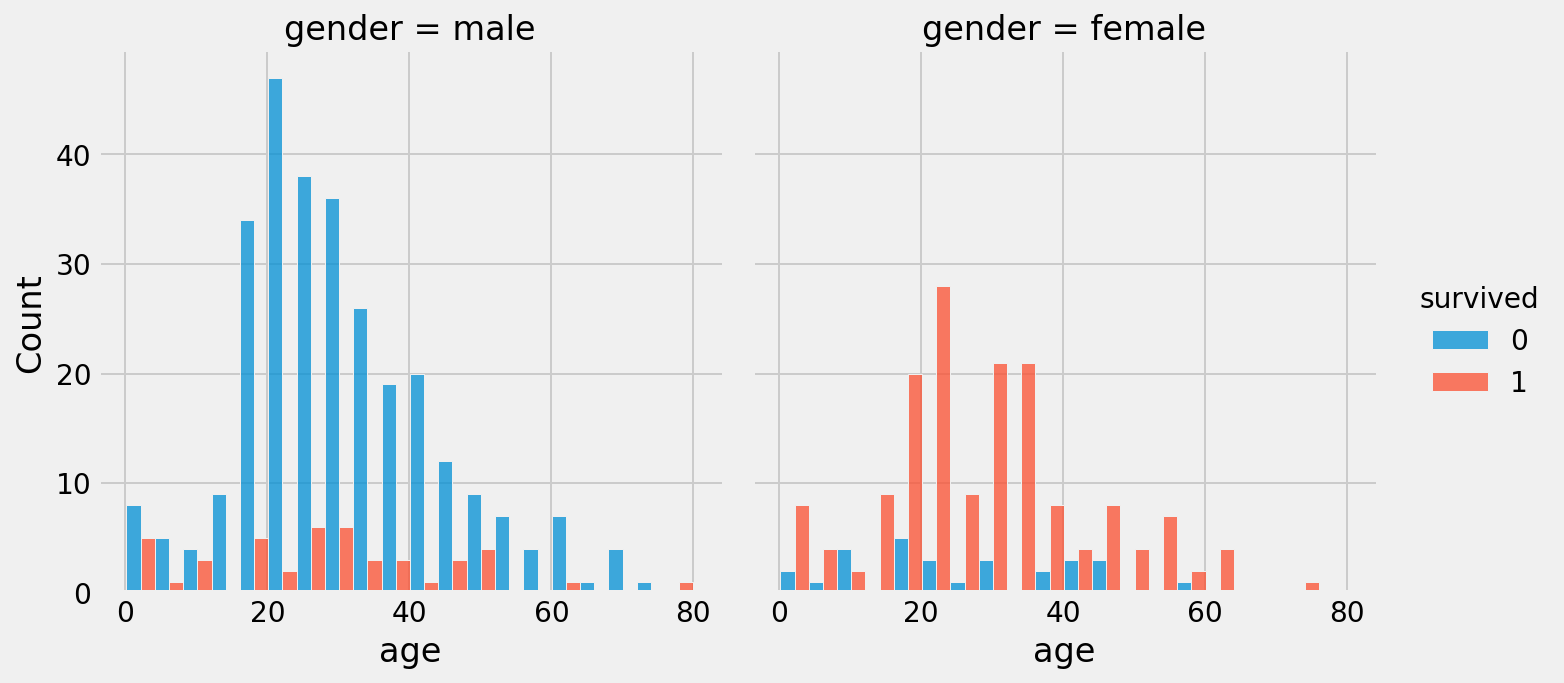

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="gender")

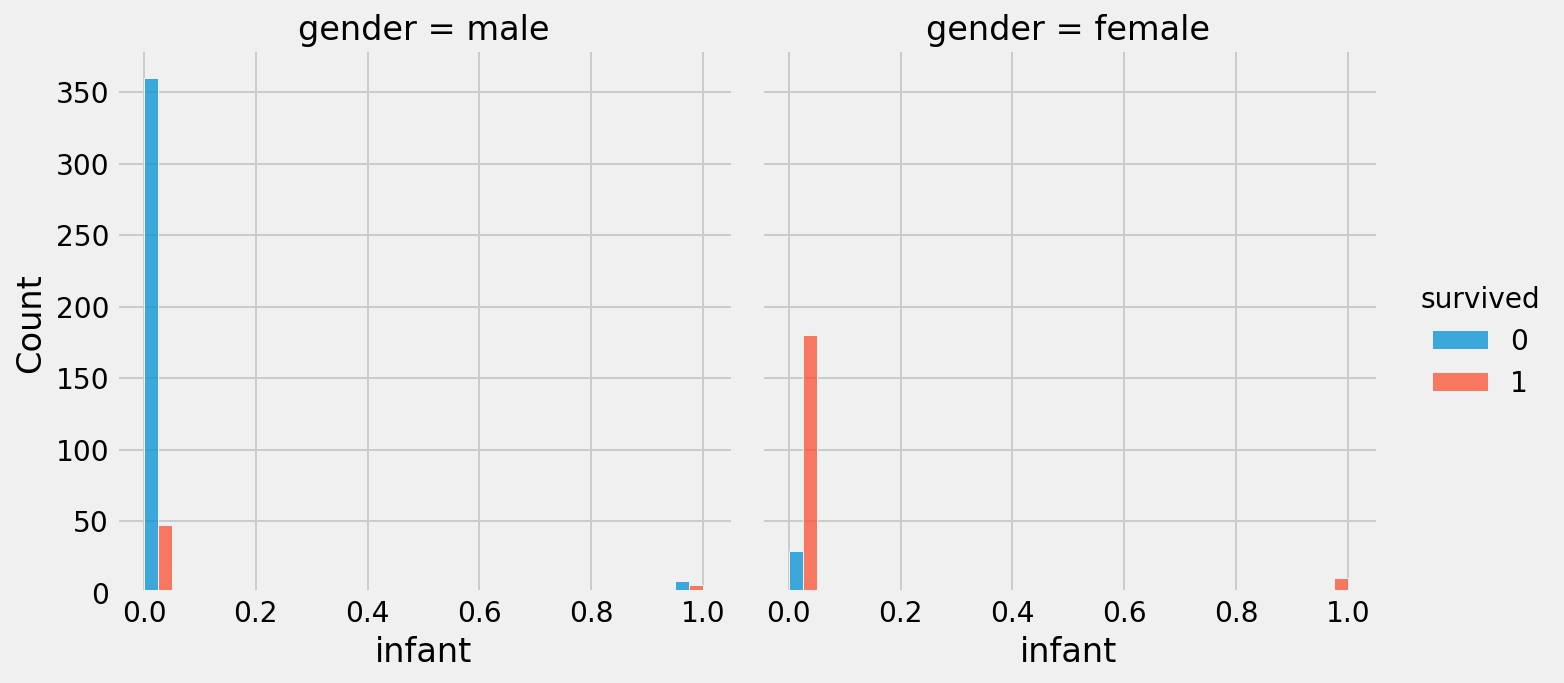

In [ ]:
sns.displot(train, x="infant", hue="survived", multiple="dodge", bins=20, col="gender")

add gender_infant

In [ ]:
train['gender_infant'] = train.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
test['gender_infant'] = test.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
ori_te['gender_infant'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)

print(f"{train['gender_infant'].nunique()} / \n {train['gender_infant'].unique()} \n")
train.shape, test.shape, ori_te.shape

4 / 
 ['male_0' 'female_0' 'female_1' 'male_1'] 



((641, 12), (275, 12), (393, 11))

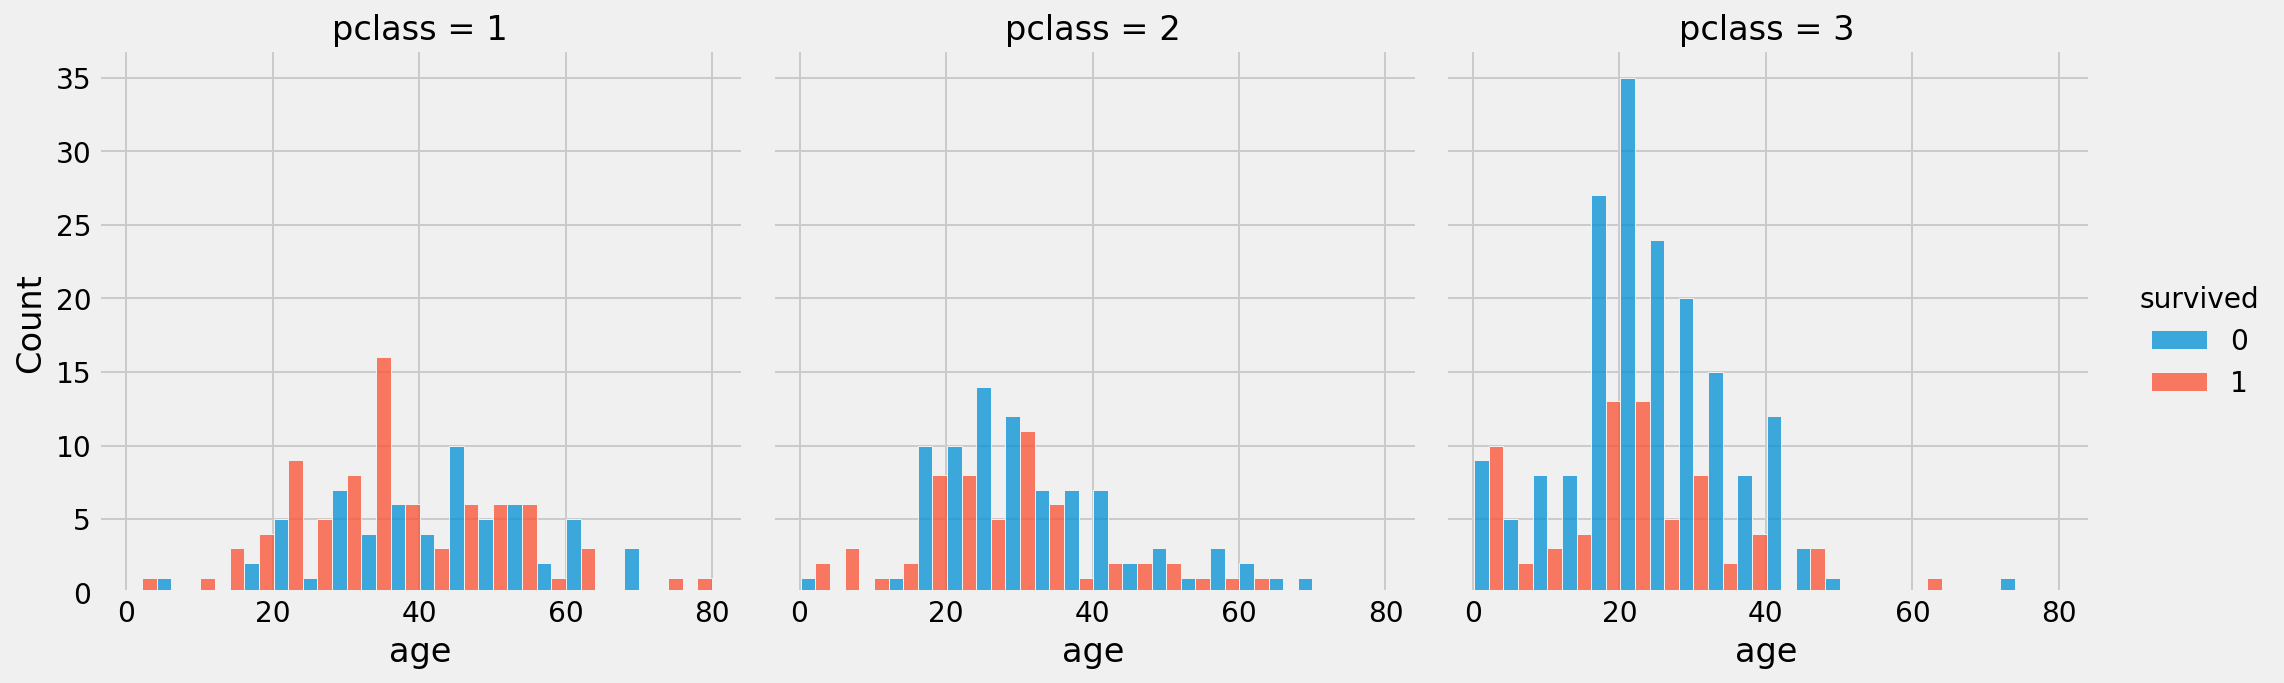

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="pclass")

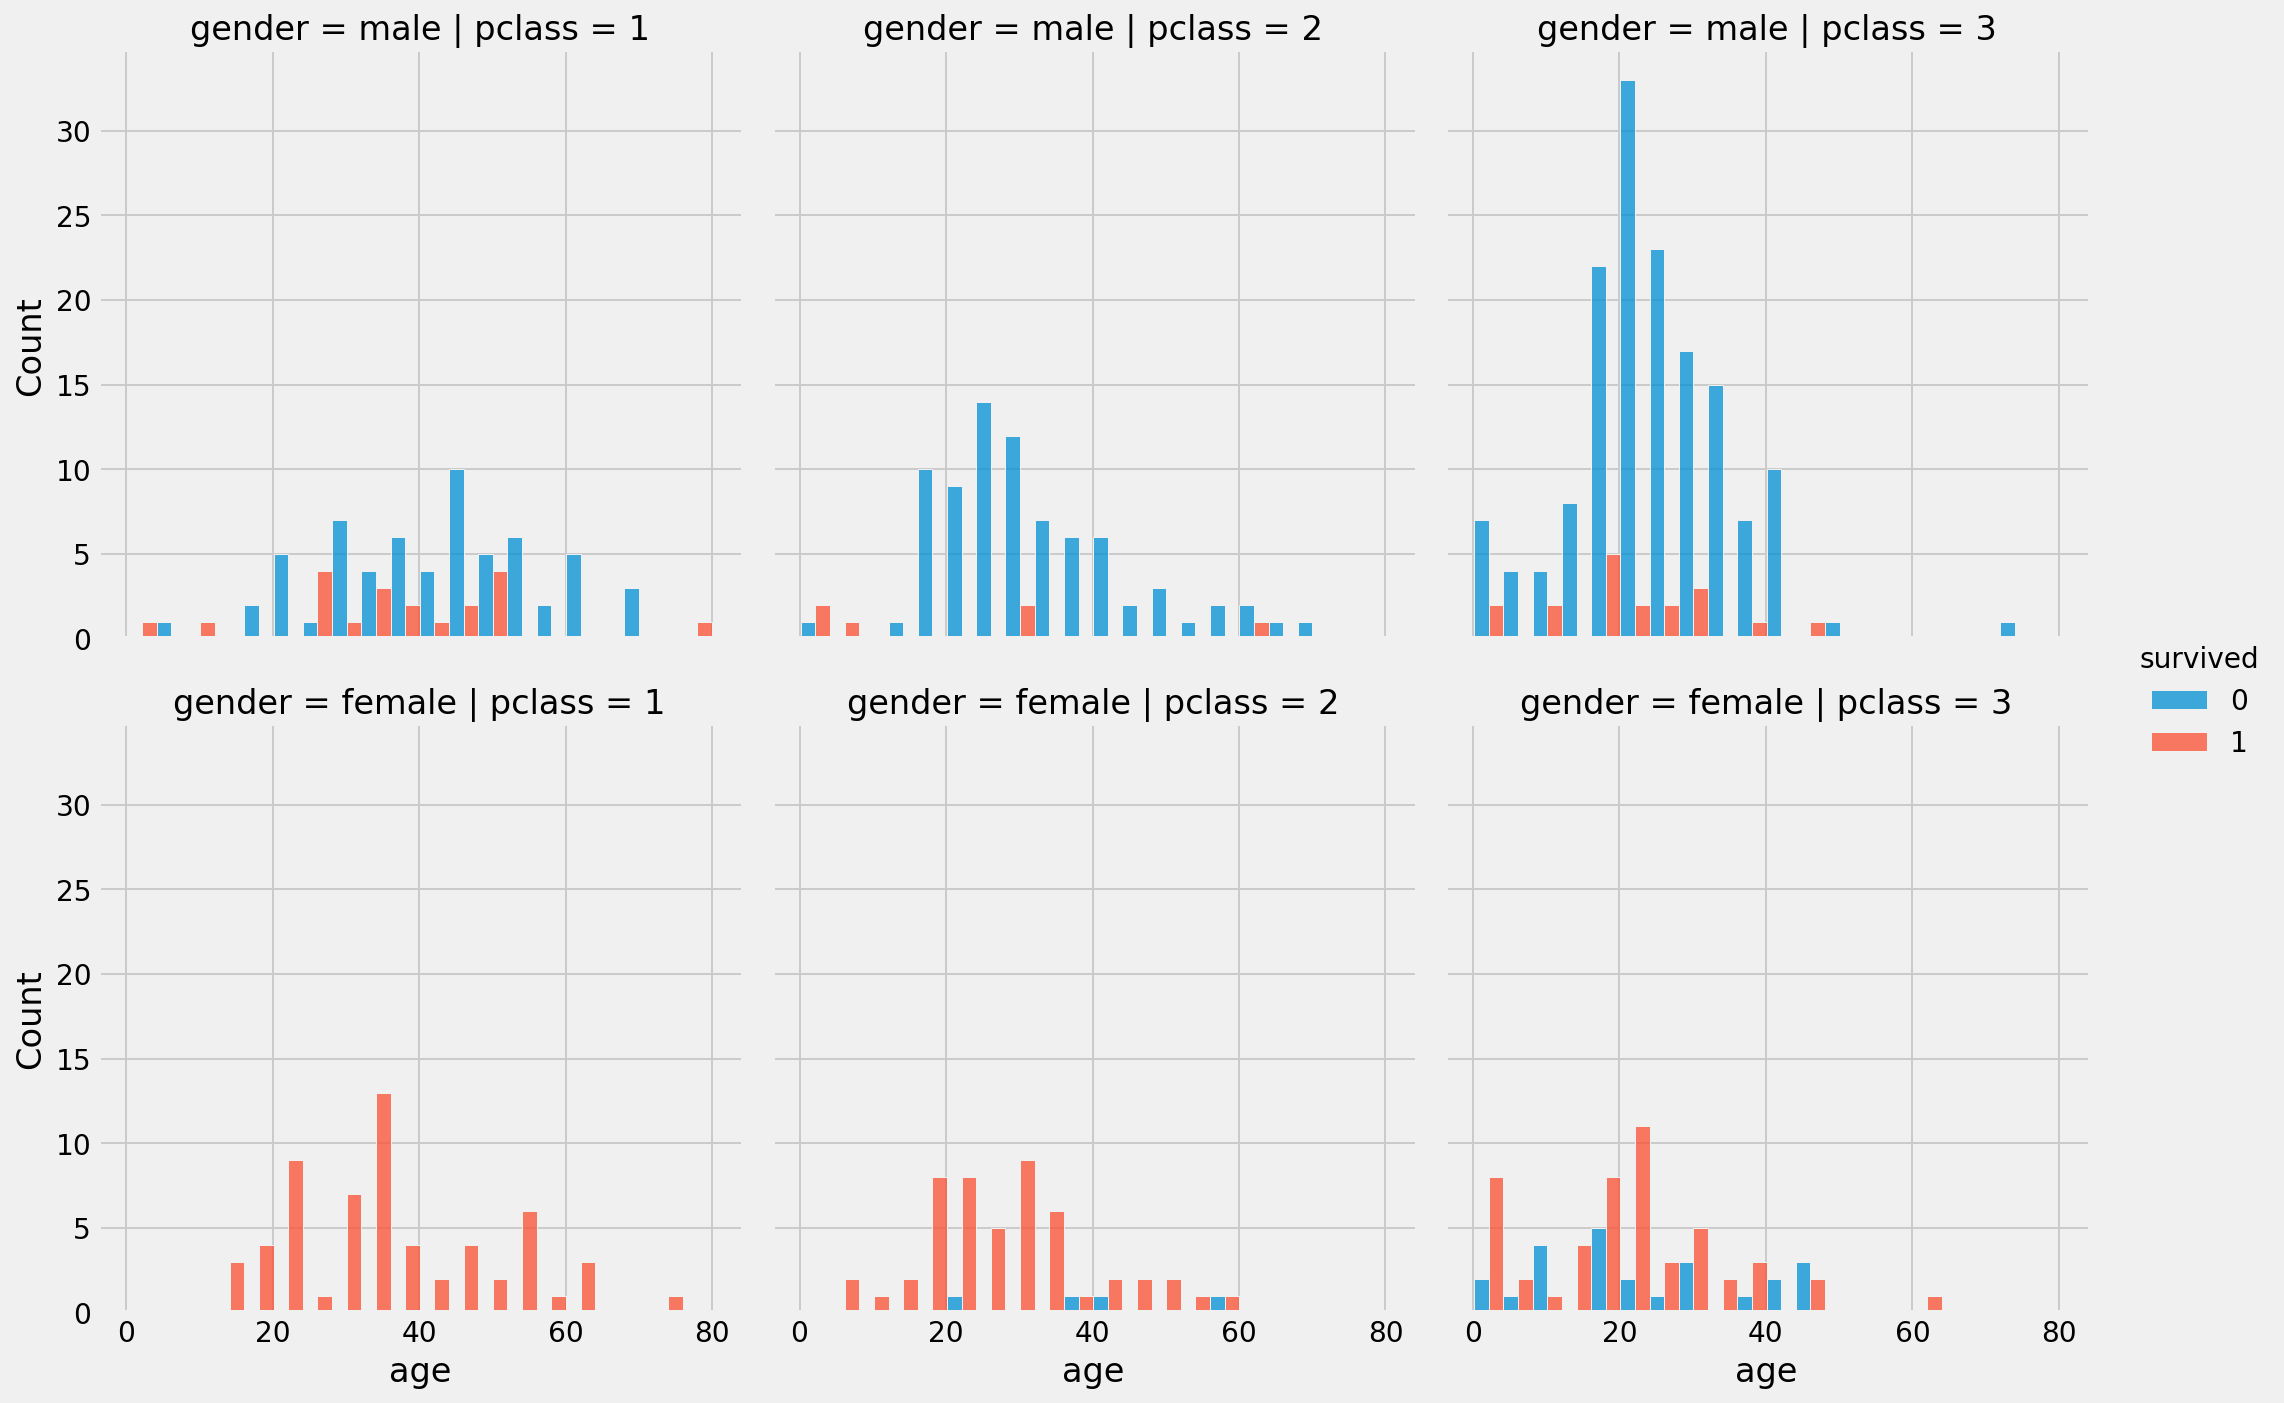

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

add gender_pclass

In [ ]:
train['gender_pclass'] = train.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
test['gender_pclass'] = test.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
ori_te['gender_pclass'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)

print(f"{train['gender_pclass'].nunique()} / \n {train['gender_pclass'].unique()} \n")
train.shape, test.shape, ori_te.shape

6 / 
 ['male_1' 'female_1' 'male_3' 'male_2' 'female_3' 'female_2'] 



((641, 13), (275, 13), (393, 12))

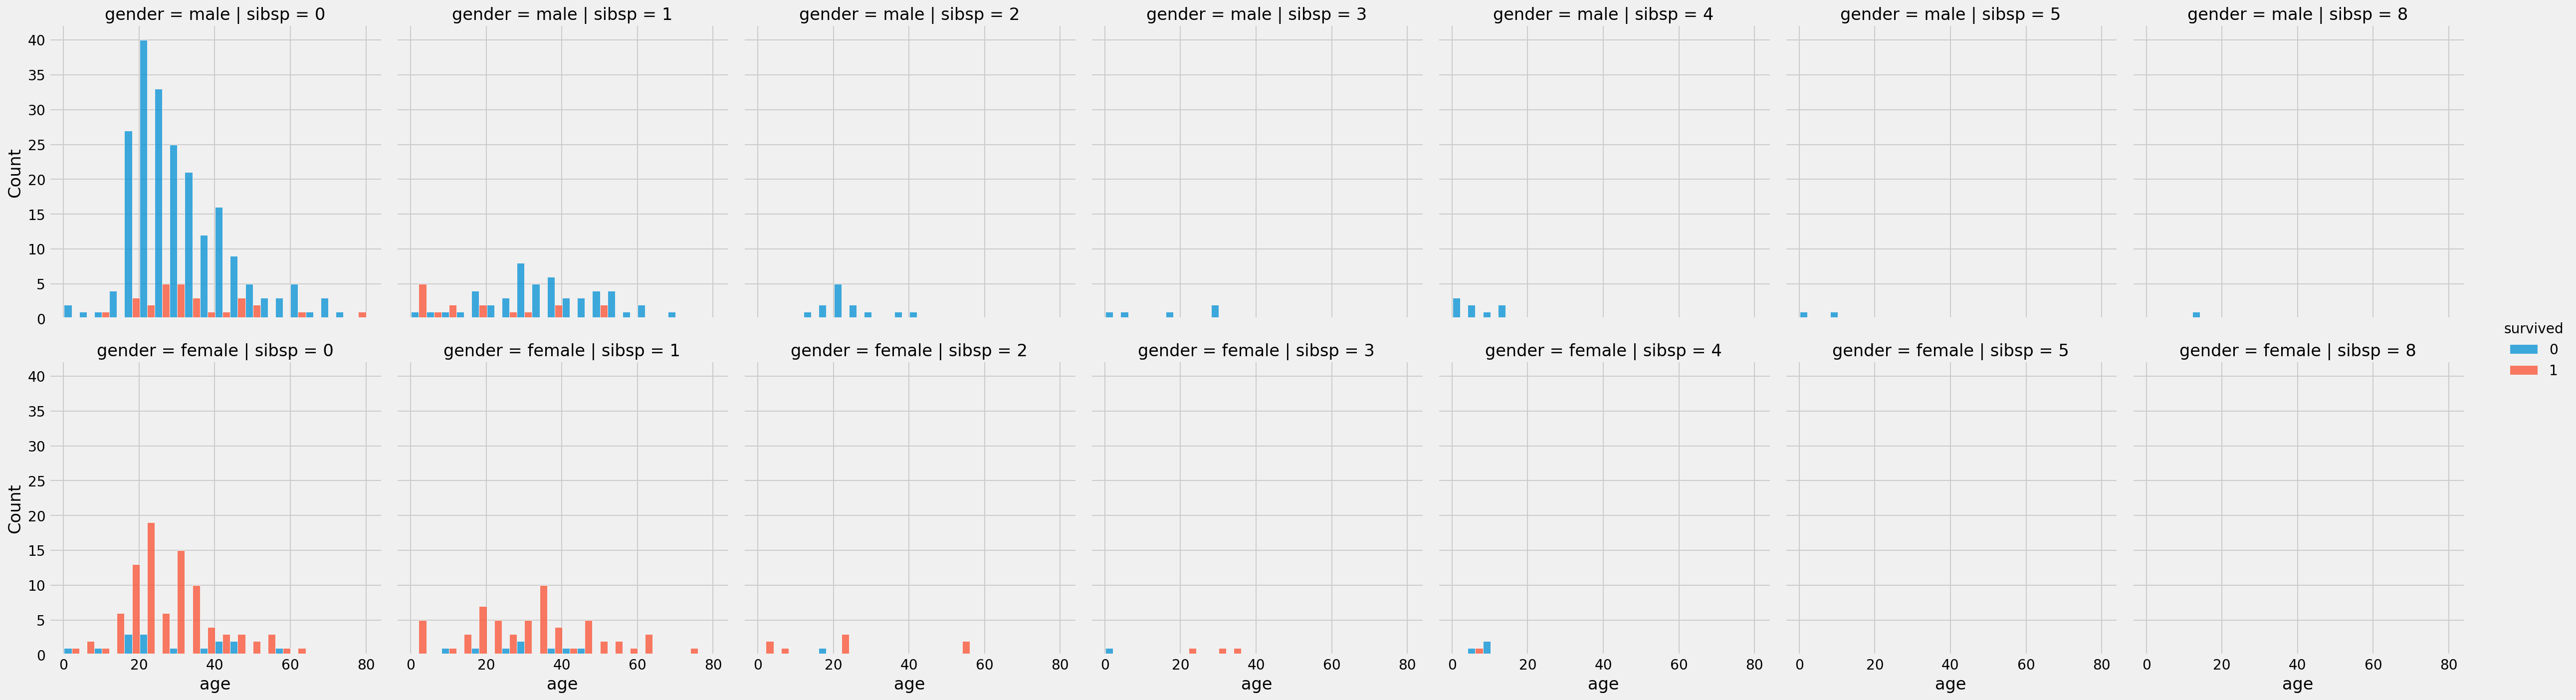

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="sibsp", row='gender')

add gender_sibsp

In [ ]:
def add_gender_sibsp(gender, sibsp):
  result = None
  try:
    if sibsp < 2:
      result = gender+'_'+str(sibsp)
    else:
      result = gender+'_2'
  except:
    pass 
  return result 

train['gender_sibsp'] = train.apply(lambda row: add_gender_sibsp(row['gender'], row['sibsp']), axis=1)
test['gender_sibsp'] = test.apply(lambda row: add_gender_sibsp(row['gender'], row['sibsp']), axis=1)
ori_te['gender_sibsp'] = ori_te.apply(lambda row: add_gender_sibsp(row['gender'], row['sibsp']), axis=1)

print(f"{train['gender_sibsp'].nunique()} / \n {train['gender_sibsp'].unique()} \n")
train.shape, test.shape, ori_te.shape

6 / 
 ['male_0' 'female_0' 'male_2' 'male_1' 'female_1' 'female_2'] 



((641, 14), (275, 14), (393, 13))

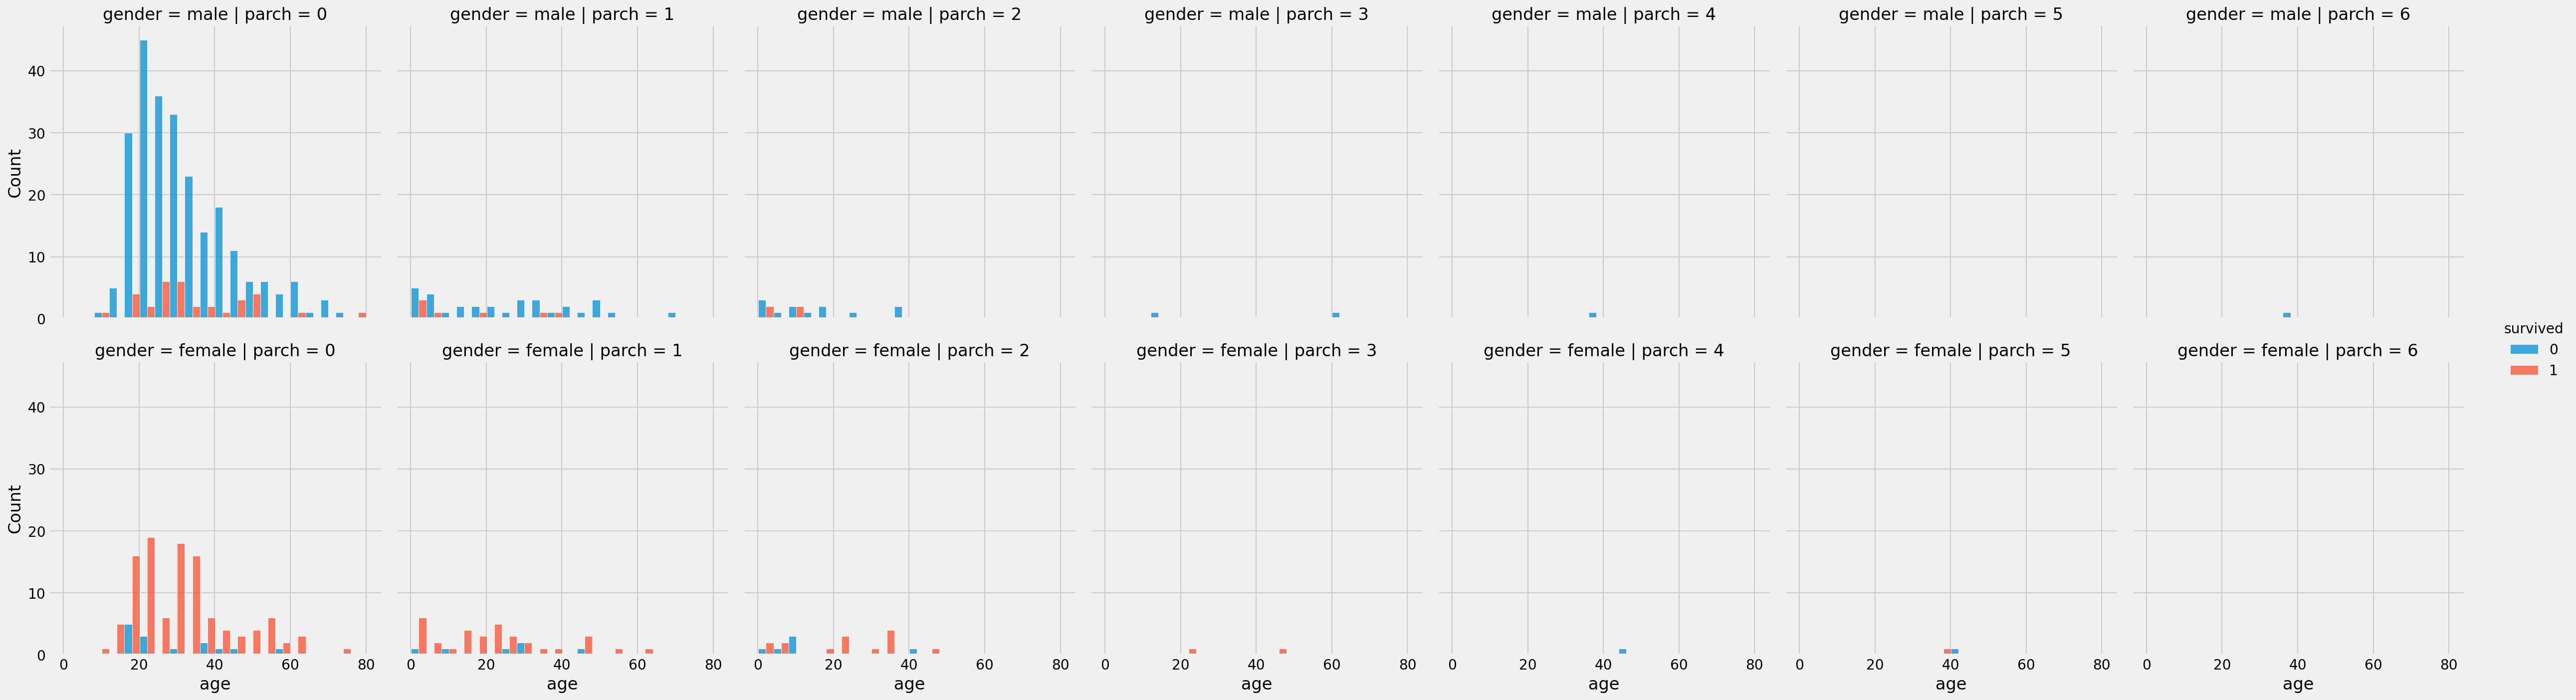

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="parch", row='gender')

add gender_parch

In [ ]:
train['parch'].unique()

array([0, 4, 2, 3, 1, 6, 5])

In [ ]:
train['gender_parch'] = train.apply(lambda row: row['gender']+'_0' if int(row['parch']) == 0 else row['gender']+'_1', axis=1)
test['gender_parch'] = test.apply(lambda row: row['gender']+'_0' if int(row['parch']) == 0 else row['gender']+'_1', axis=1)
ori_te['gender_parch'] = ori_te.apply(lambda row: row['gender']+'_0' if int(row['parch']) == 0 else row['gender']+'_1', axis=1)

print(f"{train['gender_parch'].nunique()} / \n {train['gender_parch'].unique()} \n")
train.shape, test.shape, ori_te.shape

4 / 
 ['male_0' 'female_0' 'female_1' 'male_1'] 



((641, 15), (275, 15), (393, 14))

fare

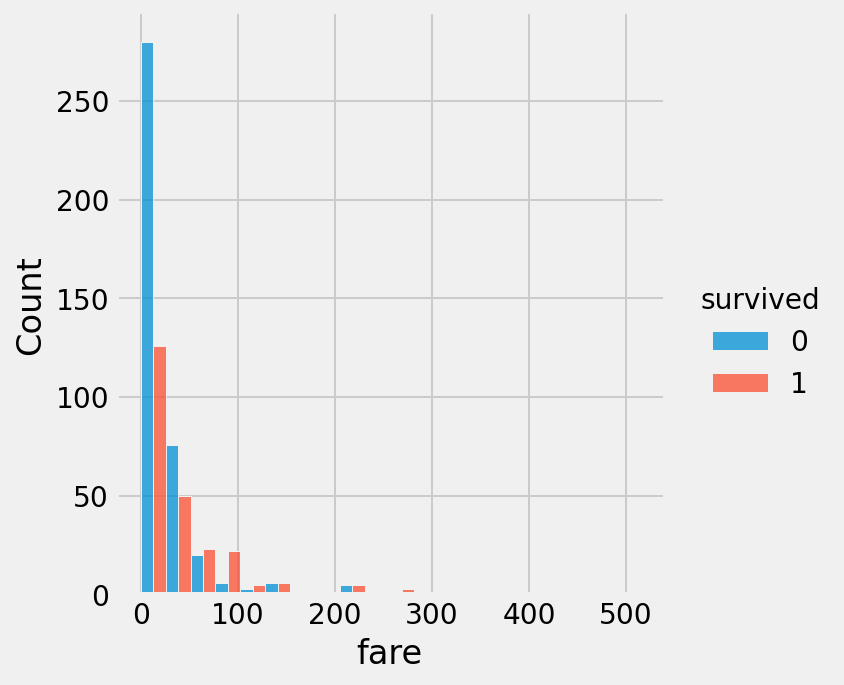

In [ ]:
sns.displot(train, x='fare', hue="survived", multiple="dodge", bins=20)

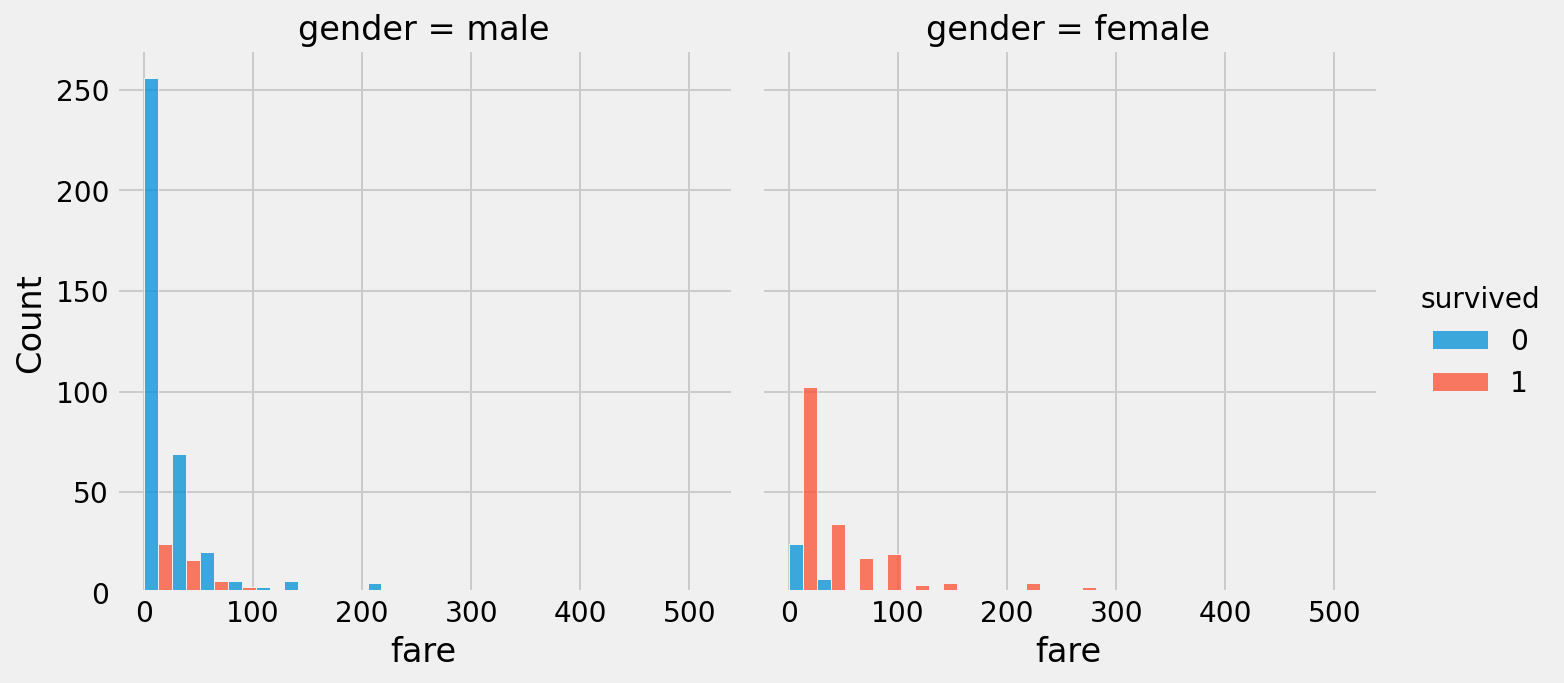

In [ ]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="gender")

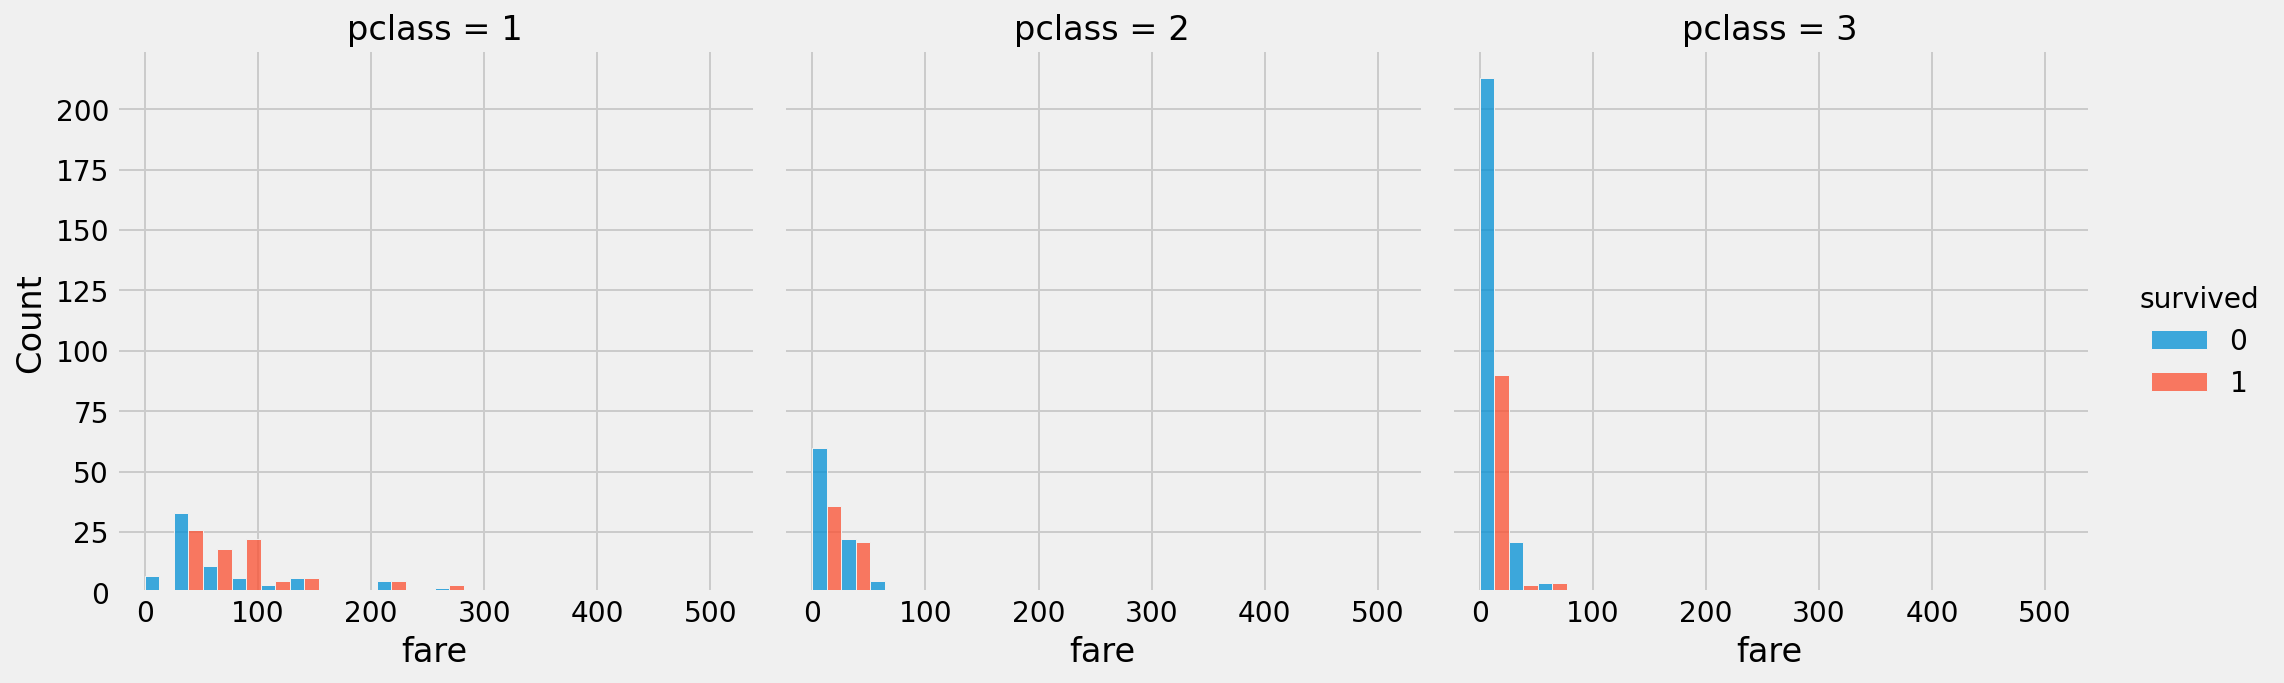

In [ ]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="pclass")

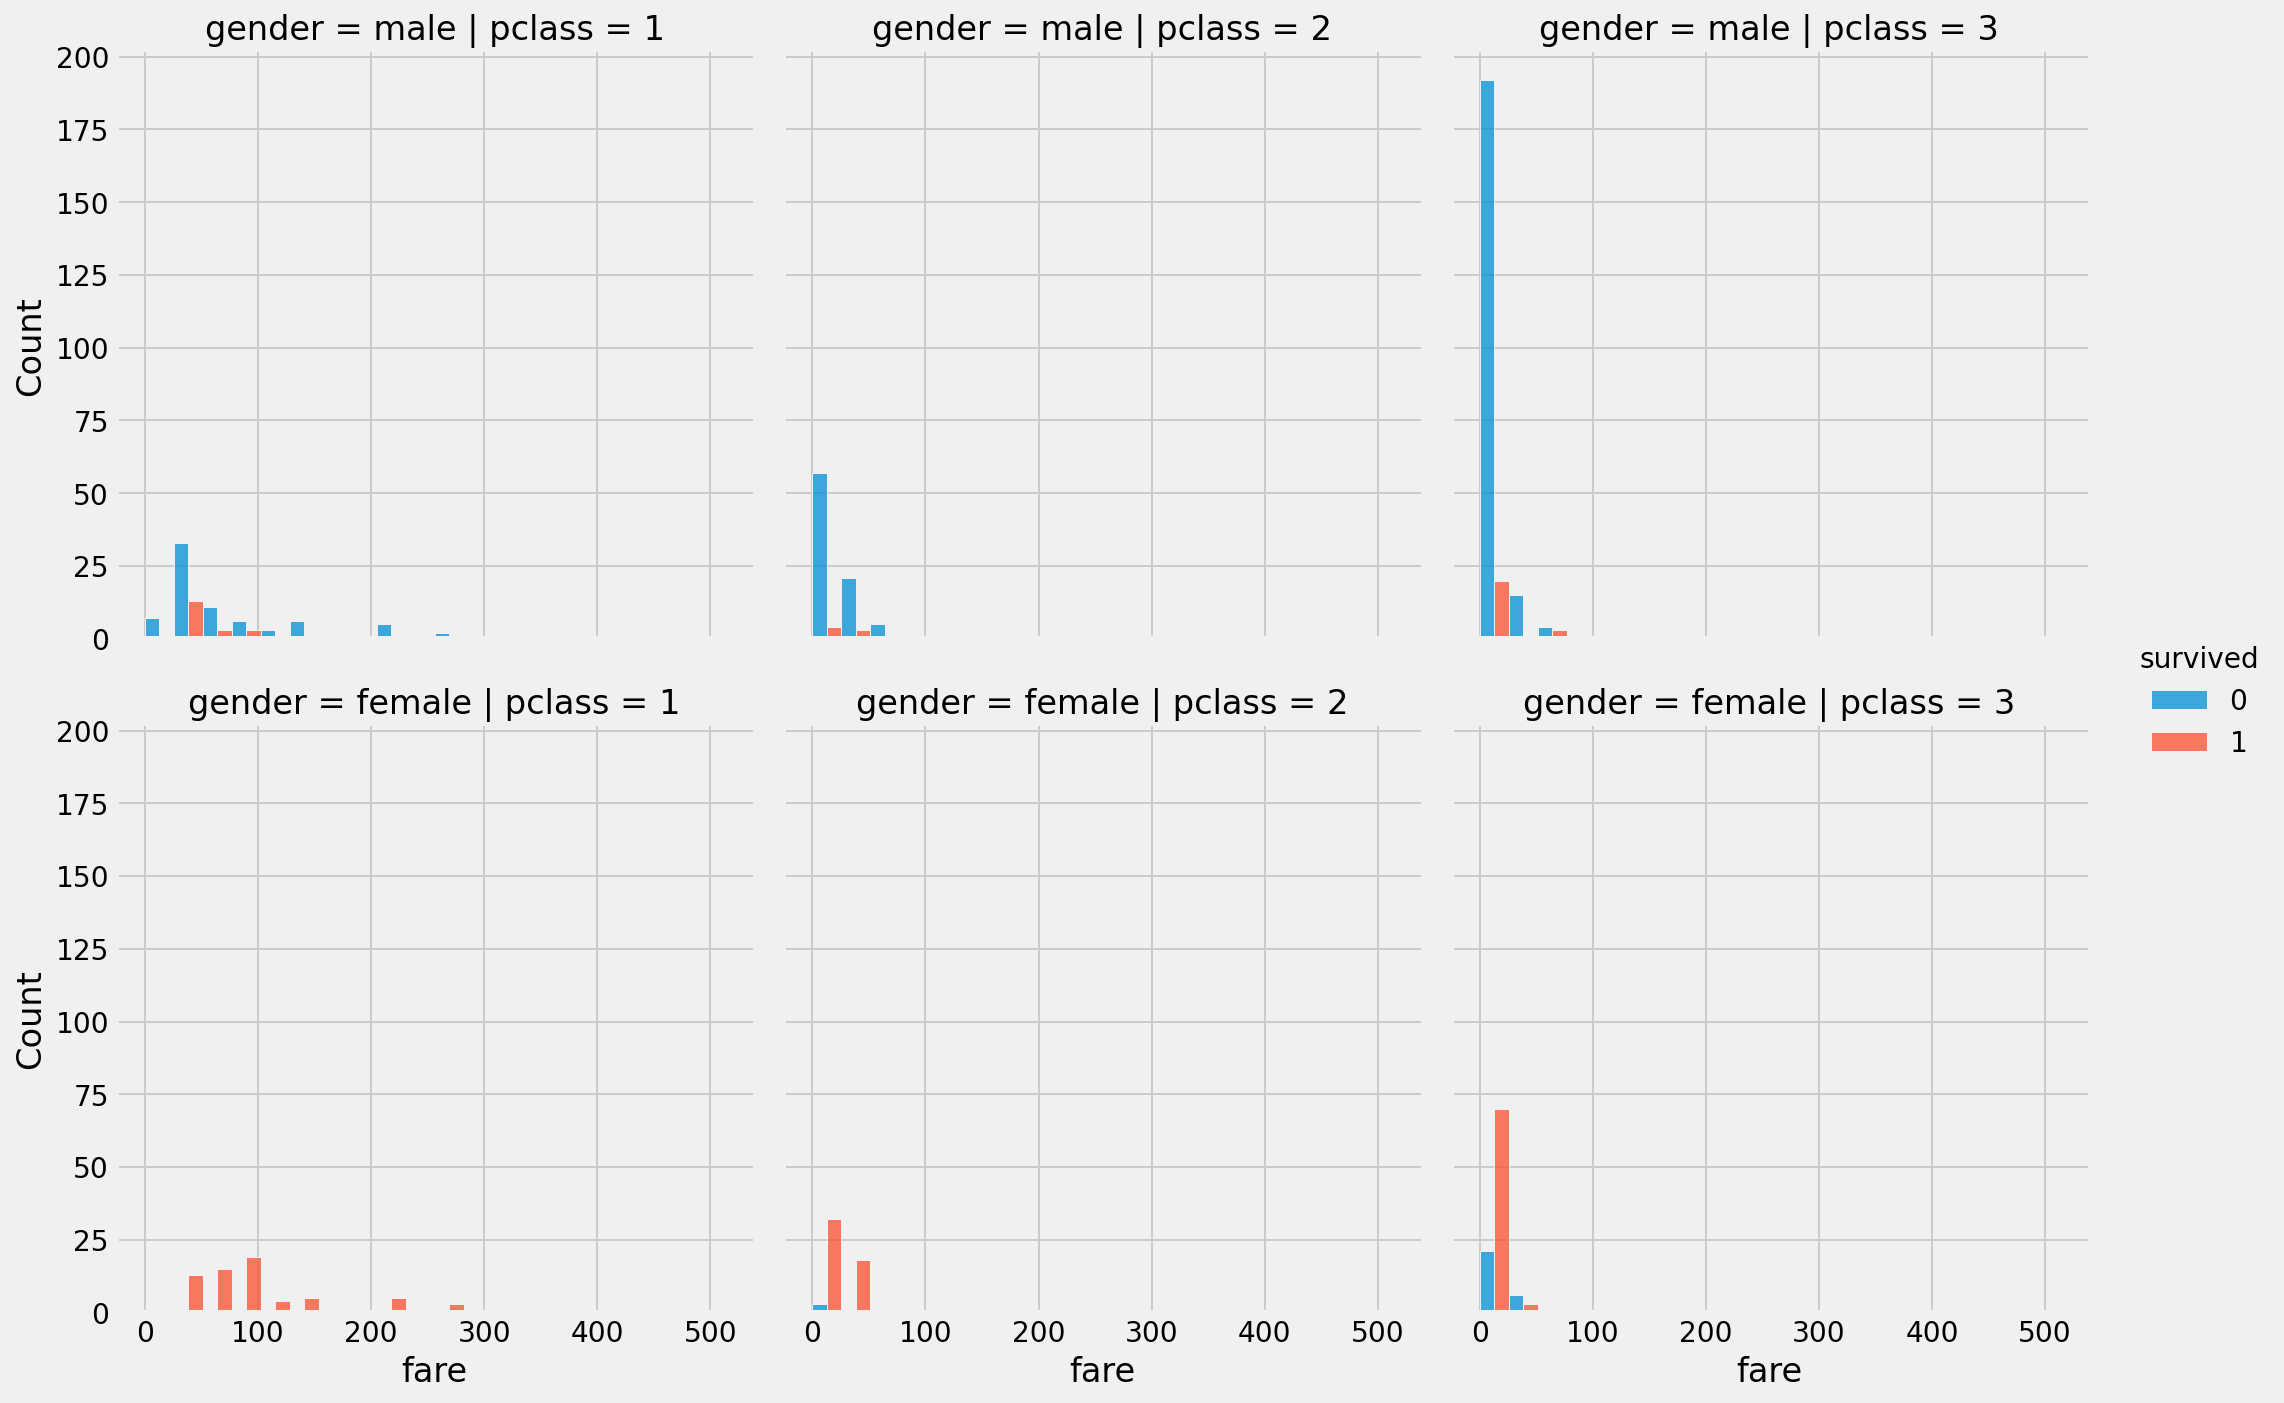

In [ ]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

In [ ]:
train.columns

Index(['survived', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'embarked', 'infant', 'gender_infant',
       'gender_pclass', 'gender_sibsp', 'gender_parch'],
      dtype='object')

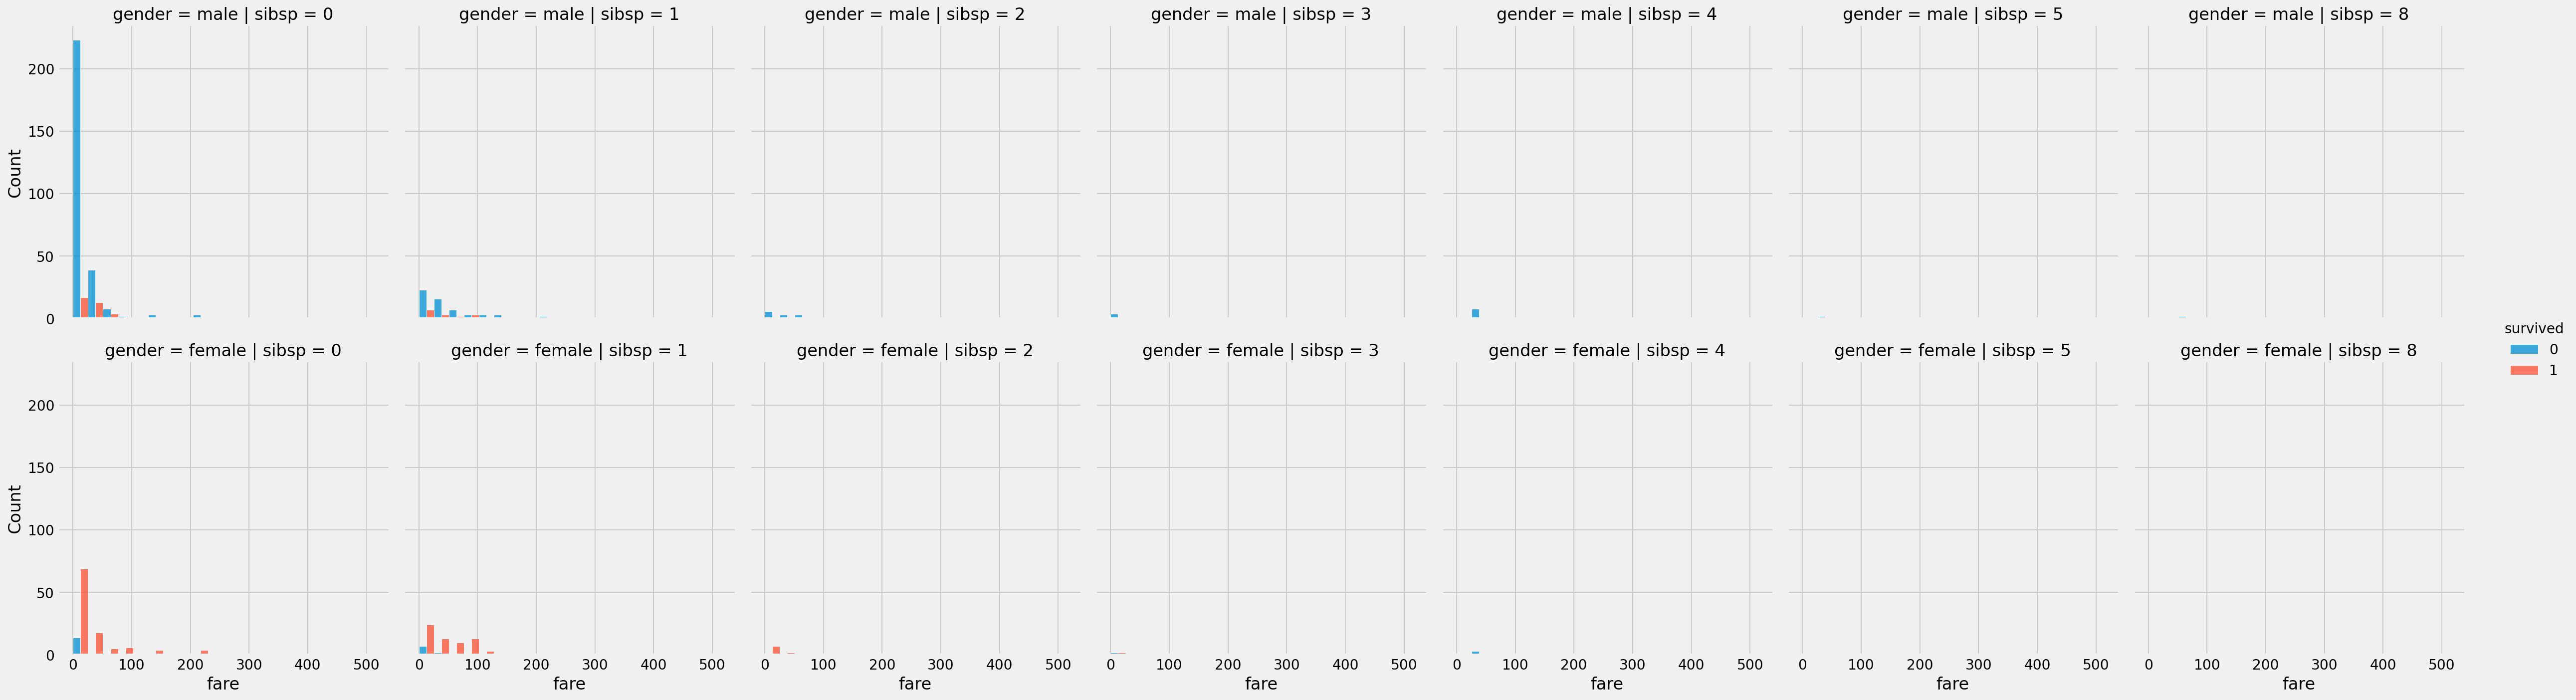

In [ ]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="sibsp", row='gender')

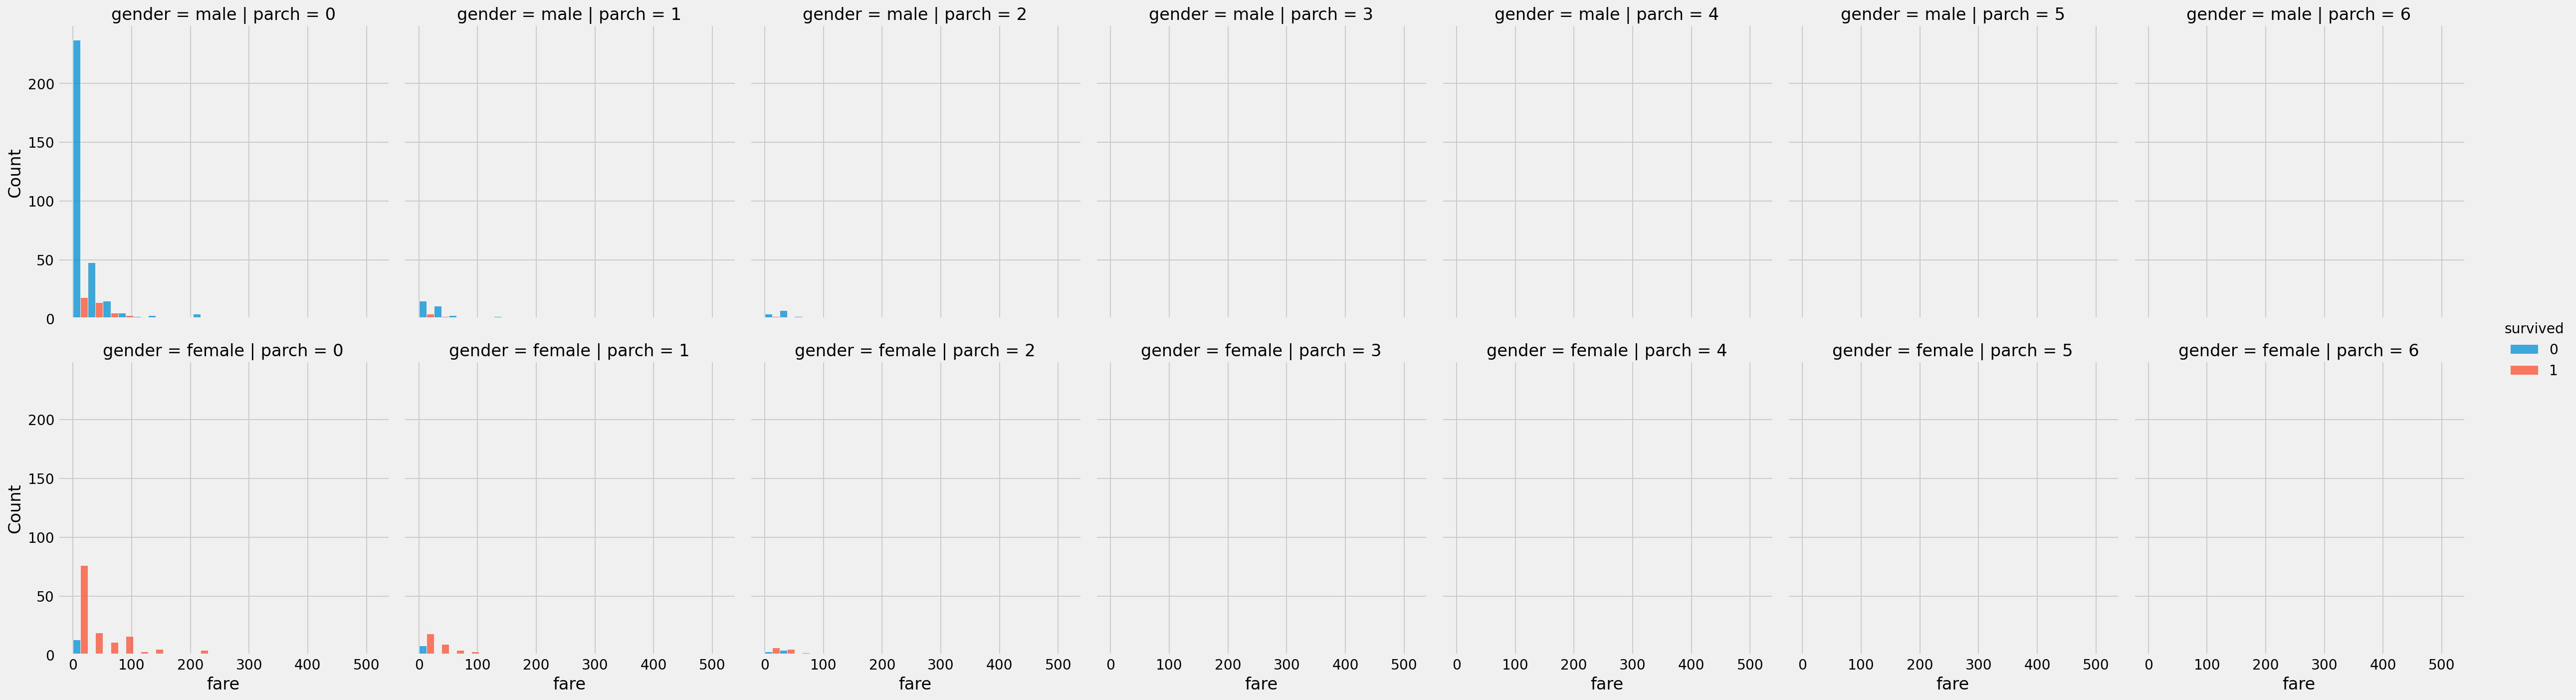

In [ ]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="parch", row='gender')

### ordinal features

In [ ]:
ordinal_cols = ['pclass', 'sibsp', 'parch'] + ['survived']

train[ordinal_cols].describe()

,pclass,sibsp,parch,survived
count,641.000000,641.000000,641.000000,641.000000
mean,2.271451,0.492980,0.324493,0.377535
std,0.837376,0.993902,0.742152,0.485149
min,1.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000
50%,3.000000,0.000000,0.000000,0.000000
75%,3.000000,1.000000,0.000000,1.000000
max,3.000000,8.000000,6.000000,1.000000


In [ ]:
train[ordinal_cols].corr()

,pclass,sibsp,parch,survived
pclass,1.000000,0.077389,0.071752,-0.214195
sibsp,0.077389,1.000000,0.399212,0.015226
parch,0.071752,0.399212,1.000000,0.075825
survived,-0.214195,0.015226,0.075825,1.000000


add reversed_pclass

In [ ]:
train['reversed_pclass'] = train['pclass'].map(lambda x: 4 - int(x))  
test['reversed_pclass'] = test['pclass'].map(lambda x: 4 - int(x))  
ori_te['reversed_pclass'] = ori_te['pclass'].map(lambda x: 4 - int(x))  

train[ordinal_cols+['reversed_pclass']].corr()

,pclass,sibsp,parch,survived,reversed_pclass
pclass,1.000000,0.077389,0.071752,-0.214195,-1.000000
sibsp,0.077389,1.000000,0.399212,0.015226,-0.077389
parch,0.071752,0.399212,1.000000,0.075825,-0.071752
survived,-0.214195,0.015226,0.075825,1.000000,0.214195
reversed_pclass,-1.000000,-0.077389,-0.071752,0.214195,1.000000


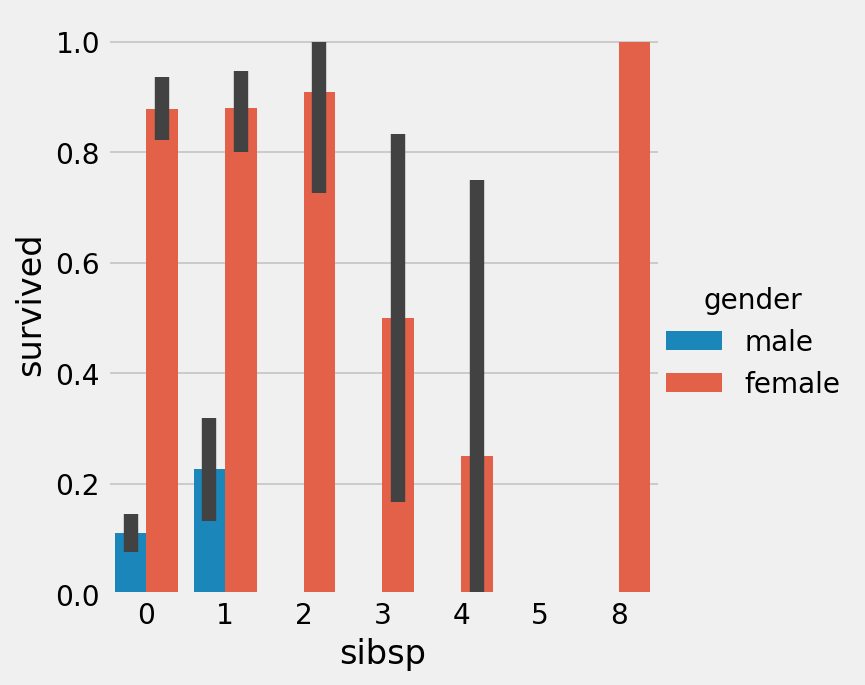

In [ ]:
sns.catplot(data=train, x="sibsp", y="survived", hue="gender", kind="bar")

In [ ]:
c1 = train['sibsp'] == 8
c2 = train['gender'] == 'female'
c = c1 & c2
train.loc[c]['survived'].mean()

1.0

In [ ]:
c1 = train['sibsp'] >= 2
c2 = train['gender'] == 'male'
c = c1 & c2
train.loc[c]['survived'].mean()

0.0

add sibsp_male

In [ ]:
for df in [train, test, ori_te]:
  c1 = df['sibsp'] >= 2
  c2 = df['gender'] == 'male'
  c = c1 & c2
  df['sibsp_male'] = c

train.shape, test.shape, ori_te.shape

((641, 17), (275, 17), (393, 16))

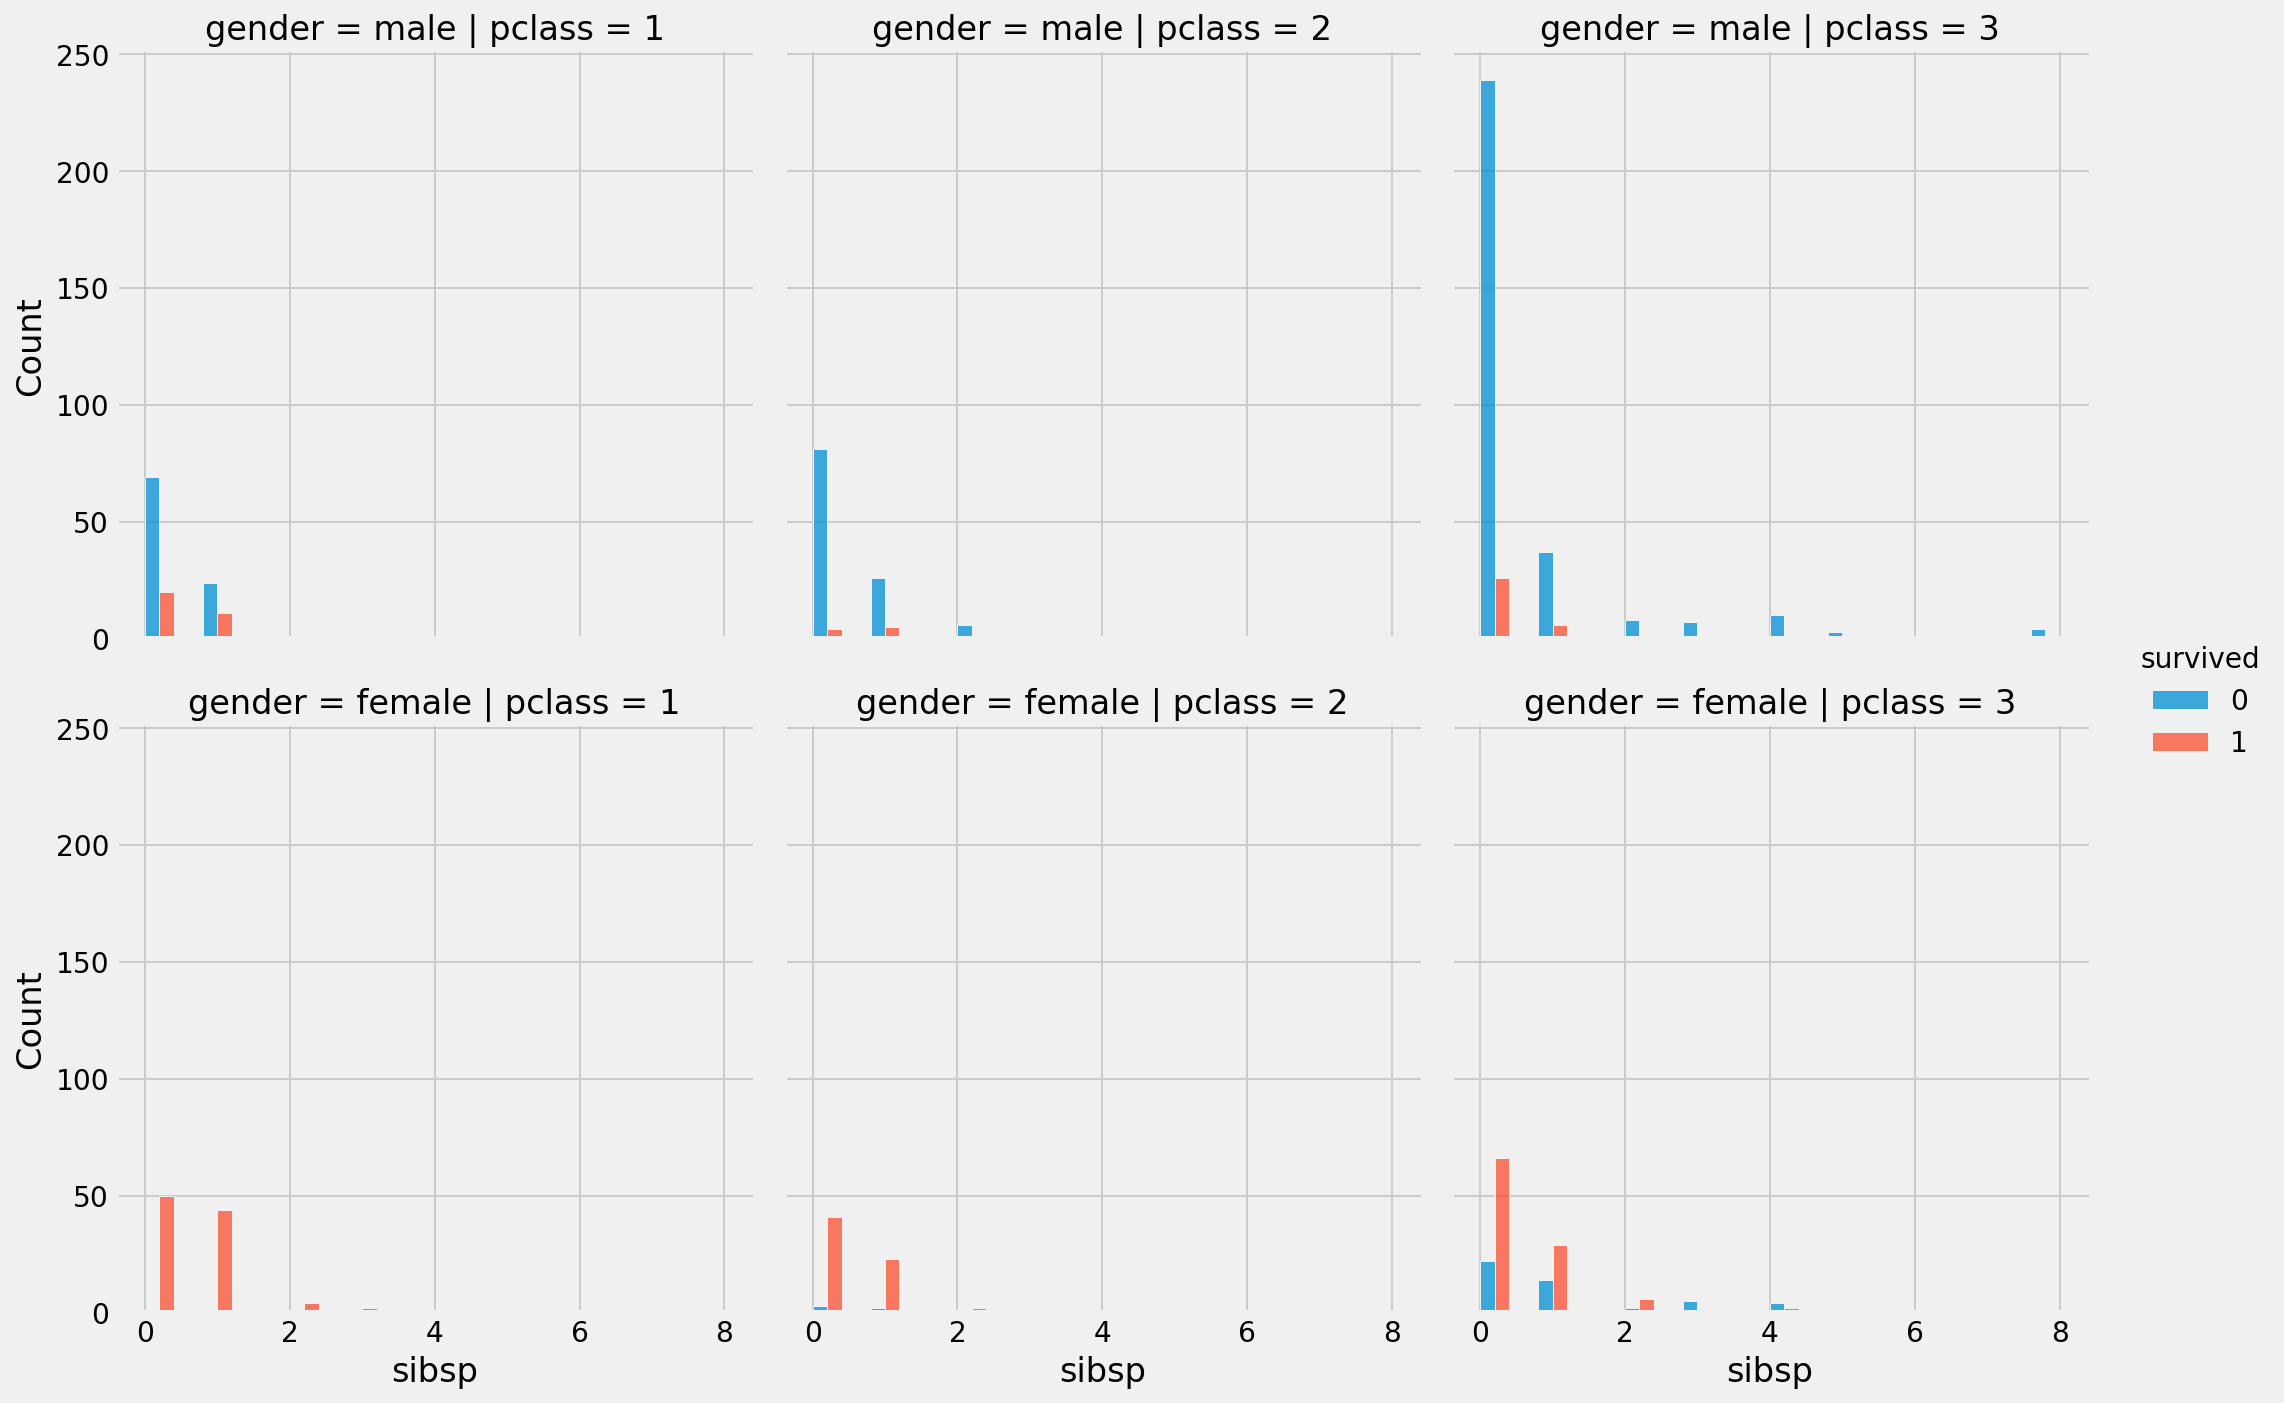

In [ ]:
sns.displot(ori_tr, x="sibsp", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

In [ ]:
train.columns

Index(['survived', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'embarked', 'infant', 'gender_infant',
       'gender_pclass', 'gender_sibsp', 'gender_parch', 'reversed_pclass',
       'sibsp_male'],
      dtype='object')

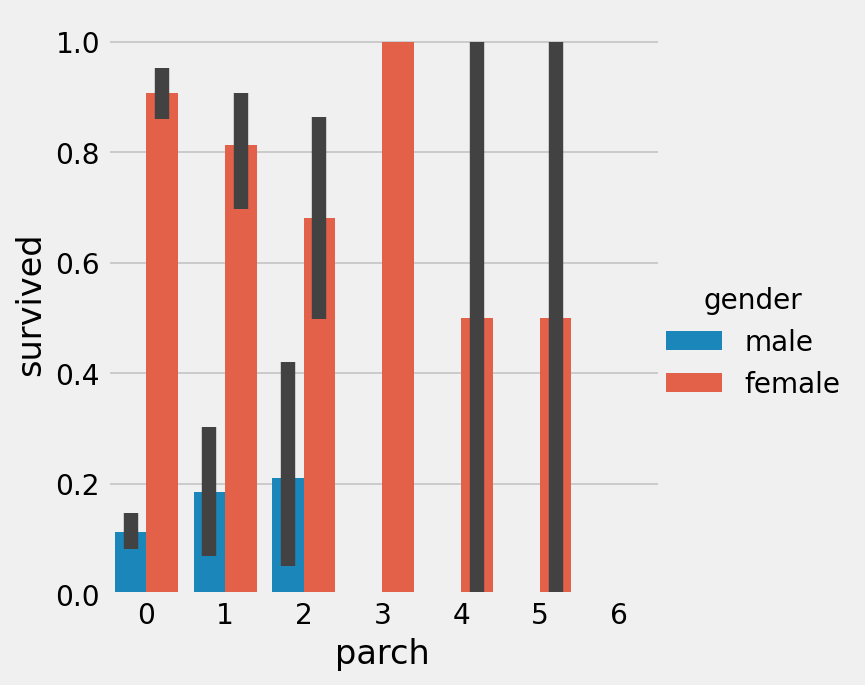

In [ ]:
sns.catplot(data=train, x="parch", y="survived", hue="gender", kind="bar")

In [ ]:
c1 = train['gender'] == 'male'
c2 = train['parch'] >= 3
c = c1 & c2
train.loc[c]['survived'].mean()

0.0

add parch_male

In [ ]:
for df in [train, test, ori_te]:
  c1 = df['parch'] >= 3
  c2 = df['gender'] == 'male'
  c = c1 & c2
  df['parch_male'] = c

train.shape, test.shape, ori_te.shape

((641, 18), (275, 18), (393, 17))

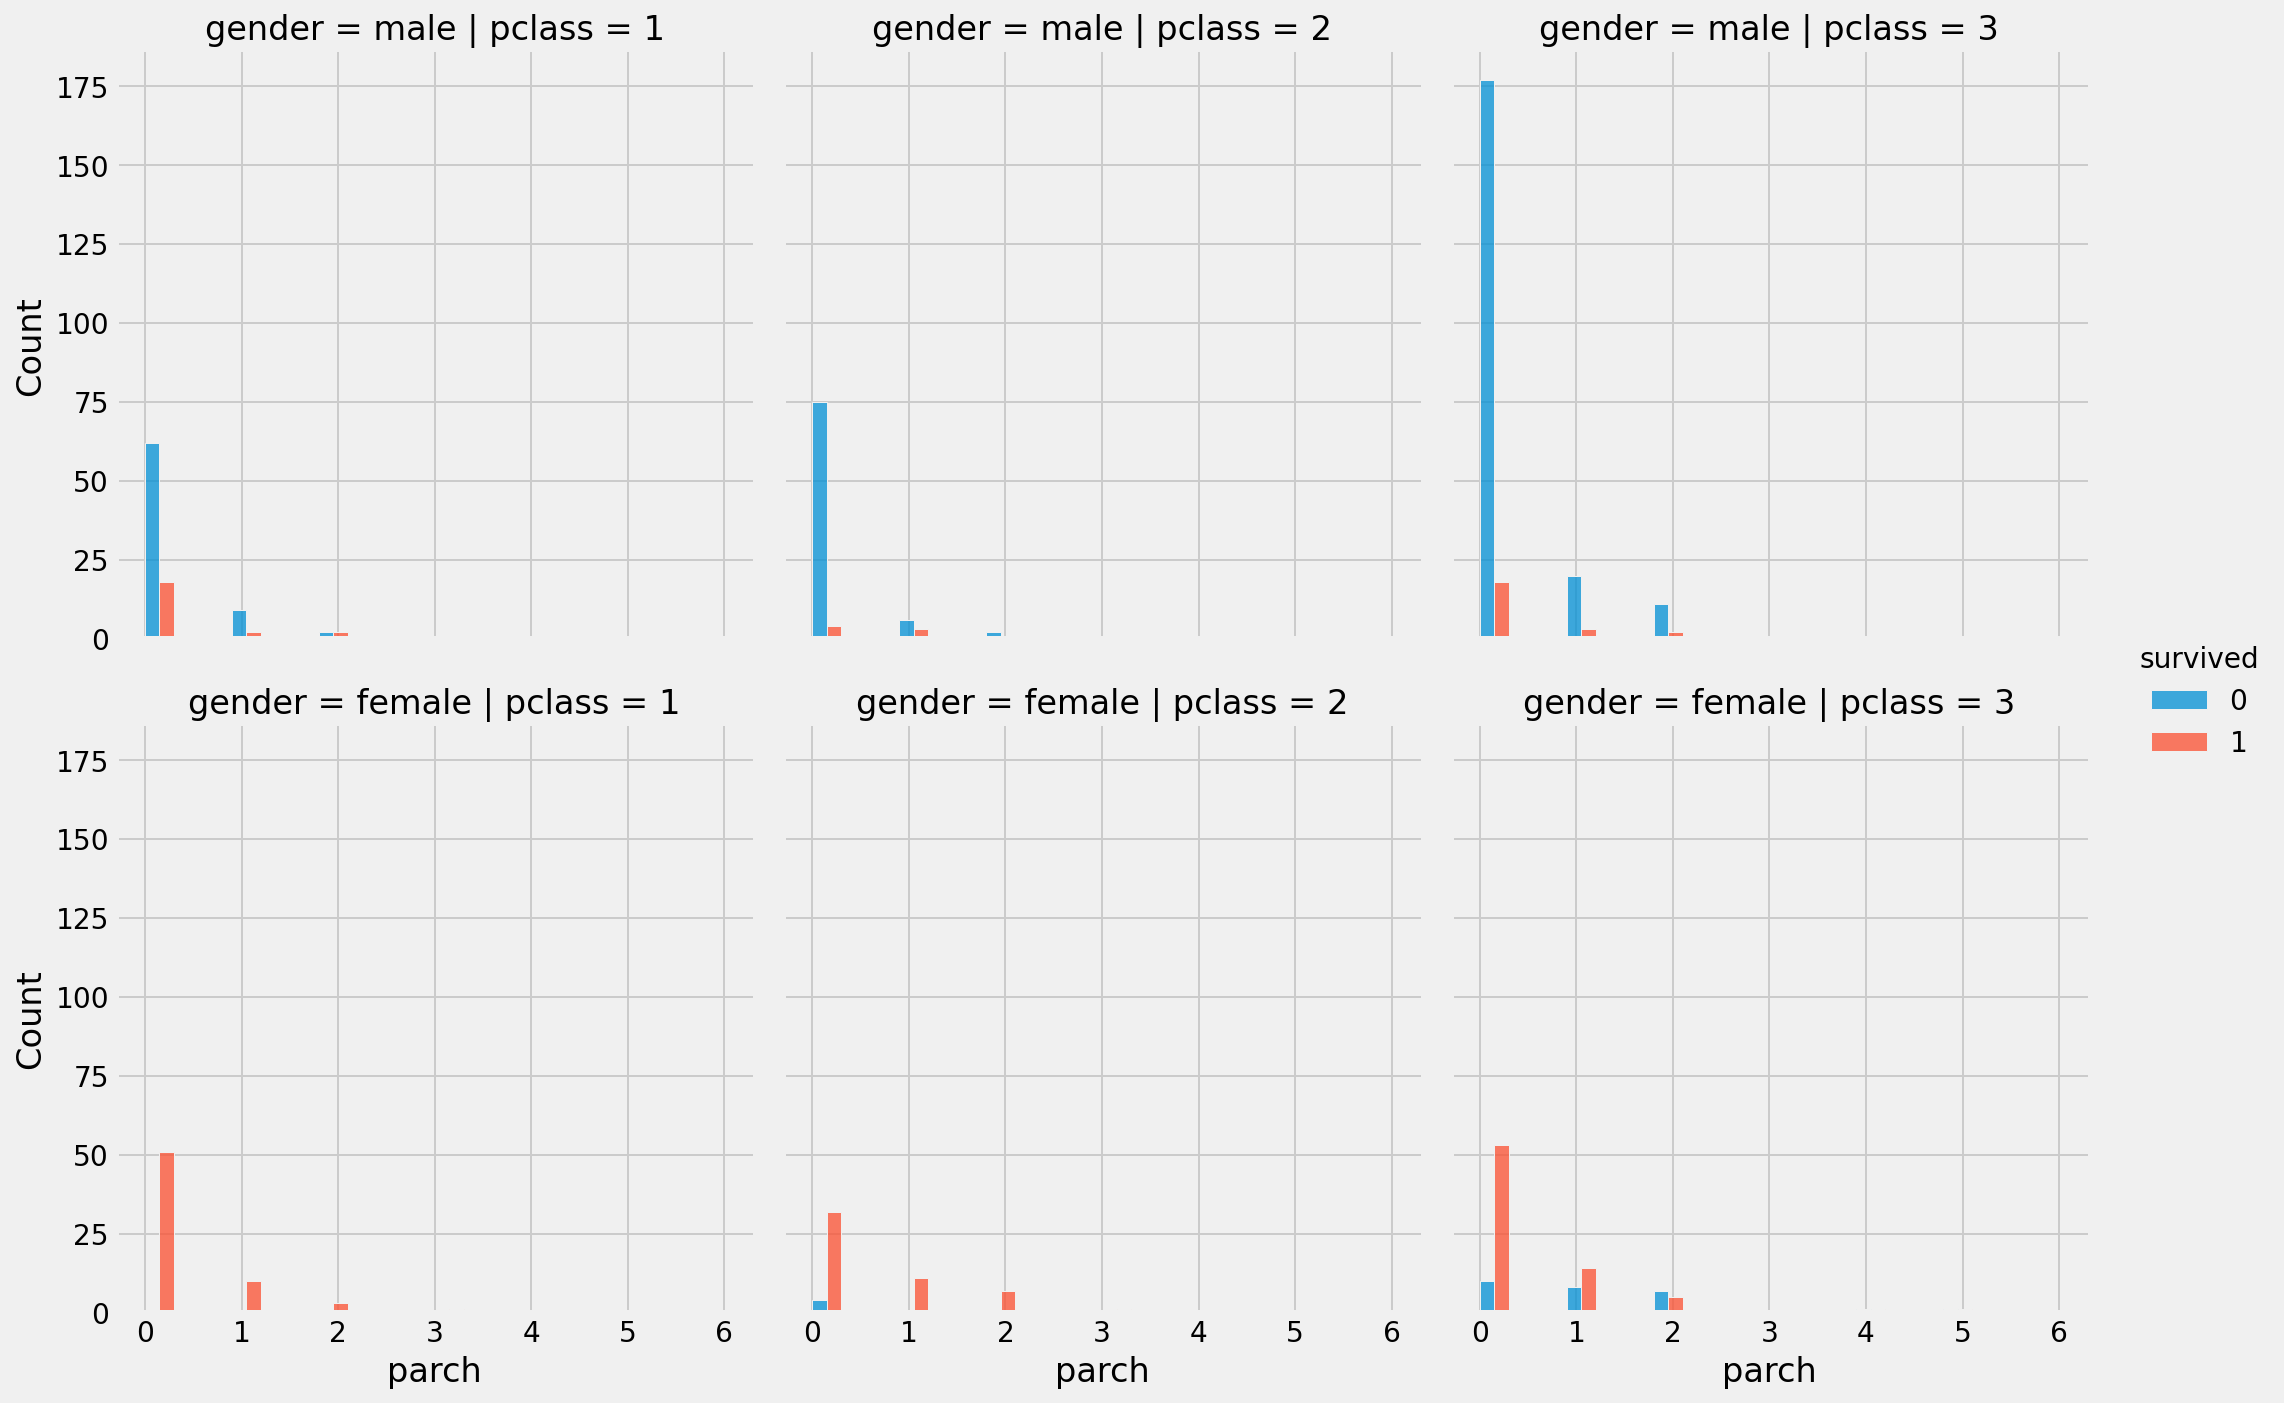

In [ ]:
sns.displot(train, x="parch", hue="survived", multiple="dodge", bins=20, col="pclass", row="gender")

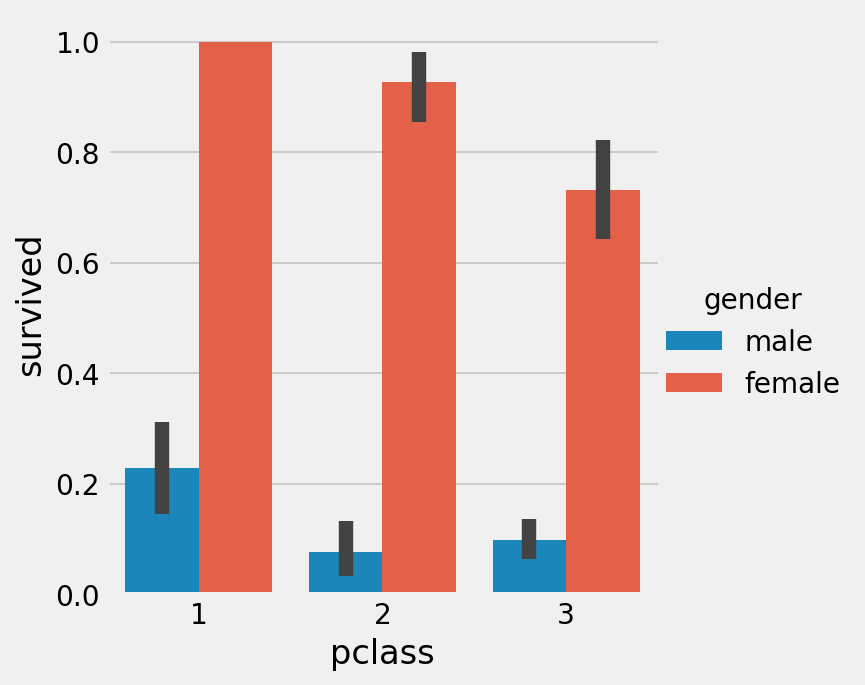

In [ ]:
sns.catplot(data=train, x="pclass", y="survived", hue="gender", kind="bar")

### categorical features

In [ ]:
train.columns

Index(['survived', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'embarked', 'infant', 'gender_infant',
       'gender_pclass', 'gender_sibsp', 'gender_parch', 'reversed_pclass',
       'sibsp_male', 'parch_male'],
      dtype='object')

In [ ]:
categorical_cols = ['gender', 'embarked'] + ['survived']
train[categorical_cols].describe(include='all')

,gender,embarked,survived
count,641,641,641.000000
unique,2,3,NaN
top,male,S,NaN
freq,420,457,NaN
mean,NaN,NaN,0.377535
std,NaN,NaN,0.485149
min,NaN,NaN,0.000000
25%,NaN,NaN,0.000000
50%,NaN,NaN,0.000000
75%,NaN,NaN,1.000000


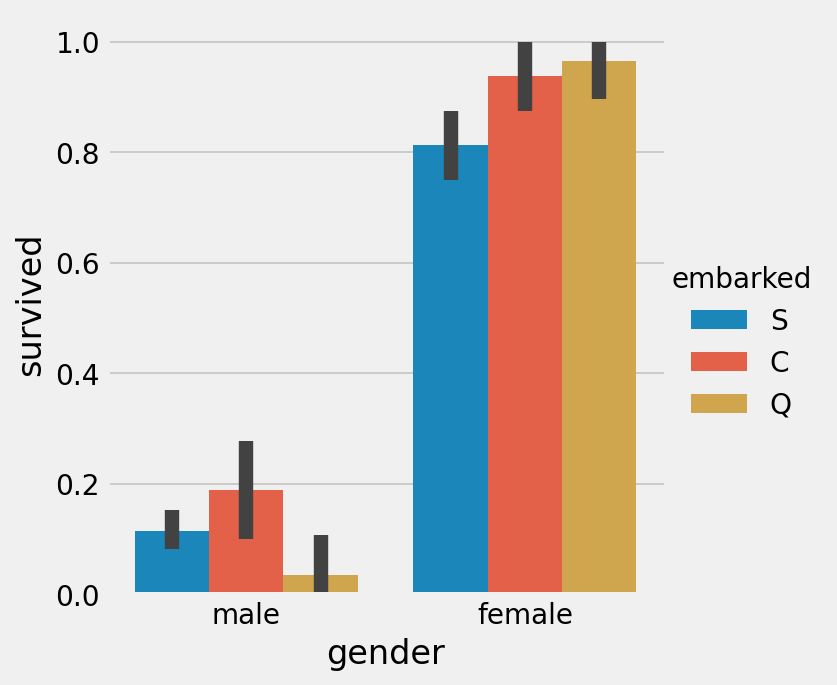

In [ ]:
sns.catplot(data=train, x="gender", y="survived", hue="embarked", kind="bar")

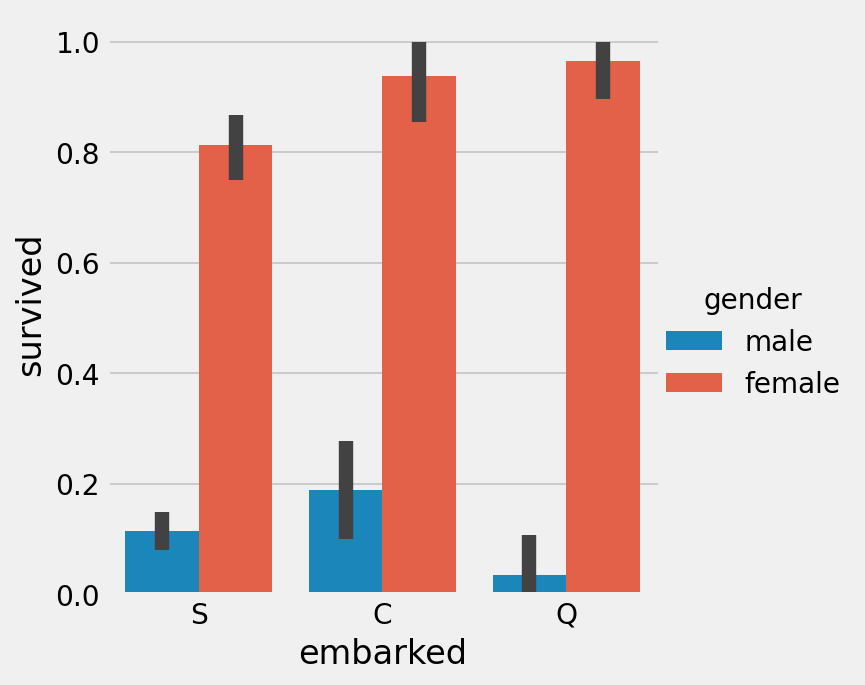

In [ ]:
sns.catplot(data=train, x="embarked", y="survived", hue="gender", kind="bar")

### text features

In [ ]:
text_cols = ['name', 'ticket']
train[text_cols].head()

,name,ticket
539,"Klaber, Mr. Herman",113028
339,"Young, Miss. Marie Grice",PC 17760
505,"Davies, Mr. Evan",SC/A4 23568
492,"Kink, Mr. Vincenz",315151
897,"Linehan, Mr. Michael",330971


add Initial_name

In [ ]:
for df in [train, test, ori_te]:
  df['Initial_name'] = df['name'].str.extract('([A-Za-z]+)\.') #lets extract the Salutations
  df.drop(['name'], axis=1, inplace=True)

train.shape, test.shape, ori_te.shape

((641, 18), (275, 18), (393, 17))

add Initial_name_type

In [ ]:
train['Initial_name'].unique()

array(['Mr', 'Miss', 'Mrs', 'Master', 'Jonkheer', 'Dr', 'Countess', 'Rev',
       'Col', 'Major', 'Sir', 'Capt'], dtype=object)

In [ ]:
train['Initial_name'].value_counts() 

Mr          371
Miss        127
Mrs          93
Master       32
Rev           5
Dr            4
Col           3
Major         2
Jonkheer      1
Countess      1
Sir           1
Capt          1
Name: Initial_name, dtype: int64

In [ ]:
dict_initial_name = {
    'Mr': 'Others',
    'Miss': 'Others',
    'Mrs': 'Others',

    'Master': 'Officer',
    'Rev': 'Officer',
    'Dr': 'Officer',
    'Col': 'Officer',
    'Major': 'Officer',
    'Capt': 'Officer',

    'Jonkheer': 'Royalty',
    'Countess': 'Royalty',
    'Sir': 'Royalty'
}


def add_initial_name_type(initial_name):
  result = 'Others'
  try:
    result = dict_initial_name[initial_name]
  except:
    pass 
  return result

for df in [train, test, ori_te]:
  df['Initial_name_type'] = df['Initial_name'].map(lambda x: add_initial_name_type(x))
  df.drop(['Initial_name'], axis=1, inplace=True)

train.shape, test.shape, ori_te.shape


((641, 18), (275, 18), (393, 17))

add len_ticket

In [ ]:
for df in [train, test, ori_te]:
  df['len_ticket'] = df['ticket'].map(lambda x: len(x.strip().split(' ')))
  df.drop(['ticket'], axis=1, inplace=True)

train.shape, test.shape, ori_te.shape

((641, 18), (275, 18), (393, 17))

### datetime features

## Missing Value

In [ ]:
(train.isnull() / train.shape[0]).sum().sort_values(ascending=False)

age                  0.184087
survived             0.000000
gender_pclass        0.000000
Initial_name_type    0.000000
parch_male           0.000000
sibsp_male           0.000000
reversed_pclass      0.000000
gender_parch         0.000000
gender_sibsp         0.000000
gender_infant        0.000000
pclass               0.000000
infant               0.000000
embarked             0.000000
fare                 0.000000
parch                0.000000
sibsp                0.000000
gender               0.000000
len_ticket           0.000000
dtype: float64

In [ ]:
(test.isnull() / test.shape[0]).sum().sort_values(ascending=False)

age                  0.225455
embarked             0.003636
survived             0.000000
gender_pclass        0.000000
Initial_name_type    0.000000
parch_male           0.000000
sibsp_male           0.000000
reversed_pclass      0.000000
gender_parch         0.000000
gender_sibsp         0.000000
gender_infant        0.000000
pclass               0.000000
infant               0.000000
fare                 0.000000
parch                0.000000
sibsp                0.000000
gender               0.000000
len_ticket           0.000000
dtype: float64

In [ ]:
(ori_te.isnull() / ori_te.shape[0]).sum().sort_values(ascending=False)

age                  0.211196
fare                 0.002545
embarked             0.002545
pclass               0.000000
gender_sibsp         0.000000
Initial_name_type    0.000000
parch_male           0.000000
sibsp_male           0.000000
reversed_pclass      0.000000
gender_parch         0.000000
gender_infant        0.000000
gender_pclass        0.000000
gender               0.000000
infant               0.000000
parch                0.000000
sibsp                0.000000
len_ticket           0.000000
dtype: float64

In [ ]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

def __get_cols_cleaning(p_pd_list:list) -> list:
  cols_cleaning = []
  for df in p_pd_list:
    # 결측치 컬럼 조회
    tmp = df.isnull().sum()
    cols_cleaning += list(tmp[df.isnull().sum() > 0].index)

  cols_cleaning = list(set(cols_cleaning))
  print(f'cols_cleaning: {cols_cleaning}')
  return cols_cleaning

def add_cols_cleaning(p_train:pd.DataFrame, p_test:pd.DataFrame, p_ori_te:pd.DataFrame) -> None:
  pd_list = [p_train, p_test, p_ori_te]
  for col in __get_cols_cleaning(pd_list):  # for col in cols_cleaning:
    for i, df in enumerate(pd_list, start=1): 
      
      if is_numeric_dtype(df[col]): # 숫자형 결측치 처리
        new_col = col+'_cleaning'
        df[new_col] = df[col]   
        # random sampling
        random_sampling = (p_train[col].dropna().sample(df[col].isnull().sum()))
        # index 부여
        random_sampling.index = df[lambda x: x[col].isnull()].index 
        # NA imputation
        df.loc[df[col].isnull(), new_col] = random_sampling
        
        # 기존 결측치 컬럼 제거
        if i == len(pd_list):
          for _df in pd_list:
            _df.drop([col], axis=1, inplace=True)
      
      else: # 범주형 결측치 처리
        df[col].fillna(p_train[col].mode().values[0], inplace=True)

  print(f'p_train: {p_train.isnull().sum().sum()} / p_test: {p_test.isnull().sum().sum()} / p_ori_te: {p_ori_te.isnull().sum().sum()}')


In [ ]:
add_cols_cleaning(train, test, ori_te)

cols_cleaning: ['fare', 'embarked', 'age']
p_train: 0 / p_test: 0 / p_ori_te: 0


## Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
train.columns

Index(['survived', 'pclass', 'gender', 'sibsp', 'parch', 'embarked', 'infant',
       'gender_infant', 'gender_pclass', 'gender_sibsp', 'gender_parch',
       'reversed_pclass', 'sibsp_male', 'parch_male', 'Initial_name_type',
       'len_ticket', 'fare_cleaning', 'age_cleaning'],
      dtype='object')

In [ ]:
scaling_cols = ['age_cleaning', 'fare_cleaning']
scaler = StandardScaler()
scaled_dfs = []

for i, df in enumerate([train, test, ori_te]):
  if not i:
    _scaled = scaler.fit_transform(df[scaling_cols])
  else:
    _scaled = scaler.transform(df[scaling_cols])

  _scaled_df = pd.DataFrame(
    _scaled, 
    columns = scaling_cols
  )

  not_scaling_cols = list(set(df.columns) - set(scaling_cols))

  scaled_dfs.append(
    pd.concat(
      [df[not_scaling_cols].reset_index(drop=True), _scaled_df.reset_index(drop=True)]
      , axis=1
    ).reset_index(drop=True)
  )

train = scaled_dfs[0]
test = scaled_dfs[1]
ori_te = scaled_dfs[2]

print(f'{train.isnull().sum().sum()} / {test.isnull().sum().sum()} / {ori_te.isnull().sum().sum()}')
train.shape, test.shape, ori_te.shape

0 / 0 / 0


((641, 18), (275, 18), (393, 17))

## Encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641 entries, 0 to 640
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pclass             641 non-null    int64  
 1   survived           641 non-null    int64  
 2   Initial_name_type  641 non-null    object 
 3   embarked           641 non-null    object 
 4   sibsp              641 non-null    int64  
 5   gender_sibsp       641 non-null    object 
 6   parch              641 non-null    int64  
 7   gender_infant      641 non-null    object 
 8   gender             641 non-null    object 
 9   infant             641 non-null    int64  
 10  parch_male         641 non-null    bool   
 11  reversed_pclass    641 non-null    int64  
 12  len_ticket         641 non-null    int64  
 13  sibsp_male         641 non-null    bool   
 14  gender_pclass      641 non-null    object 
 15  gender_parch       641 non-null    object 
 16  age_cleaning       641 non

In [ ]:
for df in [train, test, ori_te]:
  df['sibsp_male'] = df['sibsp_male'].astype("int32")
  df['parch_male'] = df['parch_male'].astype("int32")

In [ ]:
train.head()

,pclass,survived,Initial_name_type,embarked,sibsp,gender_sibsp,parch,gender_infant,gender,infant,parch_male,reversed_pclass,len_ticket,sibsp_male,gender_pclass,gender_parch,age_cleaning,fare_cleaning
0,1,0,Others,S,0,male_0,0,male_0,male,0,0,3,1,0,male_1,male_0,-0.470966,-0.114641
1,1,1,Others,C,0,female_0,0,female_0,female,0,0,3,2,0,female_1,female_0,0.438741,2.204701
2,3,0,Others,S,0,male_0,0,male_0,male,0,0,1,2,0,male_3,male_0,-0.540944,-0.507990
3,3,0,Others,S,2,male_2,0,male_0,male,0,0,1,1,1,male_3,male_0,-0.261034,-0.494967
4,3,0,Others,Q,0,male_0,0,male_0,male,0,0,1,1,0,male_3,male_0,2.258156,-0.511622


In [ ]:
train.select_dtypes(exclude=np.number)

,Initial_name_type,embarked,gender_sibsp,gender_infant,gender,gender_pclass,gender_parch
0,Others,S,male_0,male_0,male,male_1,male_0
1,Others,C,female_0,female_0,female,female_1,female_0
2,Others,S,male_0,male_0,male,male_3,male_0
3,Others,S,male_2,male_0,male,male_3,male_0
4,Others,Q,male_0,male_0,male,male_3,male_0
...,...,...,...,...,...,...,...
636,Others,S,male_0,male_0,male,male_3,male_0
637,Others,C,female_1,female_0,female,female_3,female_0
638,Others,S,female_0,female_0,female,female_3,female_1
639,Others,C,male_0,male_0,male,male_1,male_0


In [ ]:
enc_cols = list(train.select_dtypes(exclude=np.number).columns)
print(f'len_enc_cols: {len(enc_cols)}')
encoder = OneHotEncoder() 
enc_dfs = []

for i, df in enumerate([train, test, ori_te]):
  if not i:
    _encoded = encoder.fit_transform(df[enc_cols])
  else:
    _encoded = encoder.transform(df[enc_cols])

  _encoded_df = pd.DataFrame(
    _encoded.toarray(), 
    columns = encoder.get_feature_names_out()
  )

  not_enc_cols = list(set(df.columns) - set(enc_cols))
  enc_dfs.append(
    pd.concat(
      [df[not_enc_cols].reset_index(drop=True), _encoded_df.reset_index(drop=True)]
      , axis=1
    ).reset_index(drop=True)
  )

train = enc_dfs[0]
test = enc_dfs[1]
ori_te = enc_dfs[2]

print(f'{train.isnull().sum().sum()} / {test.isnull().sum().sum()} / {ori_te.isnull().sum().sum()}')
train.shape, test.shape, ori_te.shape

len_enc_cols: 7
0 / 0 / 0


((641, 39), (275, 39), (393, 38))

## Modeling

In [ ]:
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

In [ ]:
train.shape, test.shape, ori_te.shape

((641, 39), (275, 39), (393, 38))

In [ ]:
y_tr = train['survived']
X_tr = train.drop(['survived'], axis=1)

y_te = test['survived']
X_te = test.drop(['survived'], axis=1)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

((641, 38), (641,), (275, 38), (275,))

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
modelV4 = DecisionTreeClassifier(random_state=args.random_state)

modelV4.fit(X_tr, y_tr)

DecisionTreeClassifier(random_state=42)

## Evaluation

In [ ]:
score_tr = modelV4.score(X_tr, y_tr)
score_te = modelV4.score(X_te, y_te) 

score_tr, score_te  

(0.9921996879875195, 0.8218181818181818)

In [ ]:
from sklearn.metrics import roc_curve, auc 

y_pred = modelV4.predict_proba(X_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te,y_pred)
auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

model: 0.8173639226270805


In [ ]:
ori_te_pred = modelV4.predict_proba(ori_te)[:,1]
ori_te_pred.shape

(393,)

In [ ]:
df_feature_importances = pd.DataFrame(modelV4.feature_importances_, X_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances

(38, 2)


,index,0
0,gender_male,0.529397
1,fare_cleaning,0.174427
2,age_cleaning,0.158981
3,gender_pclass_female_3,0.020270
4,len_ticket,0.019318
5,gender_infant_male_1,0.011357
6,gender_sibsp_male_1,0.008197
7,pclass,0.007807
8,embarked_C,0.007681
9,gender_parch_female_0,0.007477


In [ ]:
args.results.append(
    {
        'model': 'modelV4',
        'score_tr': score_tr,
        'score_te': score_te,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': '0220'
    }
)

In [ ]:
pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False)

,model,score_tr,score_te,auc_te,len_features,feaute_importances,create_dt,ori_te_pred
0,modelV1,0.982839,0.785455,0.857259,10,"[gender_female, fare, age, pclass, sibsp, emba...",0217,NaN
6,modelV4,0.992200,0.821818,0.817364,38,"[gender_male, fare_cleaning, age_cleaning, gen...",0220,"[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
1,modelV3,0.993760,0.814545,0.812809,19,"[gender_male, fare_cleaning, age_cleaning, pcl...",0220,NaN
2,modelV4,0.990640,0.796364,0.796109,38,"[gender_female, age_cleaning, fare_cleaning, g...",0220,NaN
5,modelV3,0.992200,0.796364,0.785088,19,"[gender_male, age_cleaning, fare_cleaning, sib...",0220,"[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
3,modelV2,0.982839,0.778182,0.766616,10,"[gender_female, fare, age, pclass, sibsp, emba...",0217,NaN
4,modelV0,0.982839,0.774545,0.763580,10,"[gender_female, fare, age, pclass, sibsp, emba...",0217,NaN


# Submission

In [ ]:
df_results = pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False)
df_results

,model,score_tr,score_te,auc_te,len_features,feaute_importances,create_dt,ori_te_pred
0,modelV1,0.982839,0.785455,0.857259,10,"[gender_female, fare, age, pclass, sibsp, emba...",0217,NaN
6,modelV4,0.992200,0.821818,0.817364,38,"[gender_male, fare_cleaning, age_cleaning, gen...",0220,"[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
1,modelV3,0.993760,0.814545,0.812809,19,"[gender_male, fare_cleaning, age_cleaning, pcl...",0220,NaN
2,modelV4,0.990640,0.796364,0.796109,38,"[gender_female, age_cleaning, fare_cleaning, g...",0220,NaN
5,modelV3,0.992200,0.796364,0.785088,19,"[gender_male, age_cleaning, fare_cleaning, sib...",0220,"[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
3,modelV2,0.982839,0.778182,0.766616,10,"[gender_female, fare, age, pclass, sibsp, emba...",0217,NaN
4,modelV0,0.982839,0.774545,0.763580,10,"[gender_female, fare, age, pclass, sibsp, emba...",0217,NaN


In [ ]:
submission = pd.read_csv(args.default_submission_csv)
submission.head()

,passengerid,survived
0,916,0.5
1,917,0.5
2,918,0.5
3,919,0.5
4,920,0.5


In [ ]:
submission['survived'] = df_results.loc[3, ['ori_te_pred']].values[0]
print(f'{submission.isnull().sum().sum()}')
submission.head(10)

393


,passengerid,survived
0,916,NaN
1,917,NaN
2,918,NaN
3,919,NaN
4,920,NaN
5,921,NaN
6,922,NaN
7,923,NaN
8,924,NaN
9,925,NaN


In [ ]:
submission.to_csv(args.default_path+'result/submission_v3.csv', header=True, index=False)

In [ ]:
submission['survived'] = df_results.loc[4, ['ori_te_pred']].values[0]
submission.to_csv(args.default_path+'result/submission_v4.csv', header=True, index=False)

# Save Results

In [ ]:
df_results.drop(['ori_te_pred'], axis=1, inplace=True) 
df_results

,model,score_tr,score_te,auc_te,len_features,feaute_importances,create_dt
0,modelV1,0.982839,0.785455,0.857259,10,"[gender_female, fare, age, pclass, sibsp, emba...",0217
6,modelV4,0.992200,0.821818,0.817364,38,"[gender_male, fare_cleaning, age_cleaning, gen...",0220
1,modelV3,0.993760,0.814545,0.812809,19,"[gender_male, fare_cleaning, age_cleaning, pcl...",0220
2,modelV4,0.990640,0.796364,0.796109,38,"[gender_female, age_cleaning, fare_cleaning, g...",0220
5,modelV3,0.992200,0.796364,0.785088,19,"[gender_male, age_cleaning, fare_cleaning, sib...",0220
3,modelV2,0.982839,0.778182,0.766616,10,"[gender_female, fare, age, pclass, sibsp, emba...",0217
4,modelV0,0.982839,0.774545,0.763580,10,"[gender_female, fare, age, pclass, sibsp, emba...",0217


In [ ]:
df_results.to_json(args.save_results, orient="records")

In [ ]:
import json

load_results = None
with open(args.save_results, 'r') as file:
    load_results = json.load(file)

len(load_results)

7